# import

In [4]:
import logging
import json
import time
import random
import os
import concurrent.futures
from pathlib import Path
from tqdm import tqdm
import torch
from sentence_transformers import SentenceTransformer

# Î°úÍπÖ ÏÑ§Ï†ï
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class MedicalVectorStoreE5:
    """
    intfloat/multilingual-e5-large Î™®Îç∏ÏùÑ ÏÇ¨Ïö©Ìïú ÏùòÎ£å Îç∞Ïù¥ÌÑ∞ Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥ Íµ¨Ï∂ï ÌÅ¥ÎûòÏä§ 
    - GeminiÏôÄ ÎèôÏùºÌïú Îç∞Ïù¥ÌÑ∞ Íµ¨Ï°∞ ÏÇ¨Ïö©
    """
    def __init__(self, data_path="./medical_data", vector_store_path="./vector_stores", use_gpu=True):
        """
        Ï¥àÍ∏∞Ìôî Ìï®Ïàò
        
        Args:
            data_path: ÏùòÎ£å Îç∞Ïù¥ÌÑ∞Í∞Ä Ï†ÄÏû•Îêú Í≤ΩÎ°ú
            vector_store_path: Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥Î•º Ï†ÄÏû•Ìï† Í≤ΩÎ°ú
            use_gpu: GPU ÏÇ¨Ïö© Ïó¨Î∂Ä
        """
        self.data_path = Path(data_path)
        self.vector_store_path = Path(vector_store_path)
        
        # Í∏∞Î≥∏ ÎîîÎ†âÌÜ†Î¶¨ ÏÉùÏÑ±
        self.data_path.mkdir(parents=True, exist_ok=True)
        self.vector_store_path.mkdir(parents=True, exist_ok=True)

        # GPU ÏÇ¨Ïö© Ïó¨Î∂Ä ÌôïÏù∏
        self.device = "cuda" if use_gpu and torch.cuda.is_available() else "cpu"
        logger.info(f"Using device: {self.device}")

        # GPU Î©îÎ™®Î¶¨ Ï†ïÎ≥¥ Ï∂úÎ†•
        if torch.cuda.is_available():
            gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
            logger.info(f"GPU Î©îÎ™®Î¶¨: {gpu_memory:.1f} GB")

        # multilingual-e5-large Î™®Îç∏ Î°úÎìú
        logger.info("multilingual-e5-large Î™®Îç∏ Î°úÎìú Ï§ë...")
        self.embedding_model = SentenceTransformer(
            'intfloat/multilingual-e5-large',
            device=self.device
        )
        logger.info("ÏûÑÎ≤†Îî© Î™®Îç∏ Î°úÎìú ÏôÑÎ£å")

        # LangChain Ìò∏Ìôò ÏûÑÎ≤†Îî© ÌÅ¥ÎûòÏä§
        class E5Embeddings:
            def __init__(self, model, device):
                self.model = model
                self.device = device
            
            def embed_documents(self, texts):
                """Î¨∏ÏÑú ÏûÑÎ≤†Îî© (Î∞∞Ïπò Ï≤òÎ¶¨) - ÎåÄÏö©Îüâ Îç∞Ïù¥ÌÑ∞ ÏµúÏ†ÅÌôî"""
                # ÎåÄÏö©Îüâ Îç∞Ïù¥ÌÑ∞Î•º ÏúÑÌïú ÎèôÏ†Å Î∞∞Ïπò ÌÅ¨Í∏∞ Ï°∞Ï†ï
                batch_size = self._get_optimal_batch_size(len(texts))
                
                # E5 Î™®Îç∏ÏùÄ Î¨∏ÏÑú Í≤ÄÏÉâÏùÑ ÏúÑÌï¥ 'passage: ' Ï†ëÎëêÏÇ¨ ÏÇ¨Ïö©
                prefixed_texts = [f"passage: {text}" for text in texts]
                embeddings = self.model.encode(
                    prefixed_texts,
                    batch_size=batch_size,
                    show_progress_bar=False,
                    convert_to_tensor=False,
                    normalize_embeddings=True  # Ï†ïÍ∑úÌôî
                )
                return embeddings.tolist()
            
            def embed_query(self, text):
                """ÏøºÎ¶¨ ÏûÑÎ≤†Îî©"""
                # E5 Î™®Îç∏ÏùÄ ÏøºÎ¶¨Î•º ÏúÑÌï¥ 'query: ' Ï†ëÎëêÏÇ¨ ÏÇ¨Ïö©
                prefixed_text = f"query: {text}"
                embedding = self.model.encode(
                    [prefixed_text],
                    show_progress_bar=False,
                    convert_to_tensor=False,
                    normalize_embeddings=True
                )
                return embedding[0].tolist()
            
            def _get_optimal_batch_size(self, text_count):
                """ÌÖçÏä§Ìä∏ ÏàòÏôÄ GPU Î©îÎ™®Î¶¨Ïóê Îî∞Î•∏ ÏµúÏ†Å Î∞∞Ïπò ÌÅ¨Í∏∞ Í≤∞Ï†ï"""
                if not torch.cuda.is_available():
                    return 4
                
                gpu_memory_gb = torch.cuda.get_device_properties(0).total_memory / 1024**3
                
                if gpu_memory_gb >= 16:
                    return min(32, text_count)
                elif gpu_memory_gb >= 8:
                    return min(16, text_count)
                else:
                    return min(8, text_count)
            
            def __call__(self, text):
                """FAISSÏóêÏÑú ÏßÅÏ†ë Ìò∏Ï∂úÎêòÎäî Í≤ΩÏö∞Î•º ÏúÑÌïú Î©îÏÑúÎìú"""
                if isinstance(text, list):
                    return self.embed_documents(text)
                else:
                    return self.embed_query(text)
        
        # ÏûÑÎ≤†Îî© Ïù∏Ïä§ÌÑ¥Ïä§ ÏÉùÏÑ±
        self.embeddings = E5Embeddings(self.embedding_model, self.device)

        from langchain.text_splitter import RecursiveCharacterTextSplitter

        # Î¨∏ÏÑú Î∂ÑÌï†Í∏∞ ÏÑ§Ï†ï (E5 Î™®Îç∏Ïóê Ï†ÅÌï©ÌïòÍ≤å Ï°∞Ï†ï)
        self.text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=512,  # E5 Î™®Îç∏Ïùò ÏµúÎåÄ ÌÜ†ÌÅ∞ Í∏∏Ïù¥ Í≥†Î†§
            chunk_overlap=50,
            separators=["\n\n", "\n", ". ", " ", ""],
            length_function=len
        )

    def _embed_documents_batch(self, texts, batch_size=None):
        """
        Î∞∞Ïπò Îã®ÏúÑÎ°ú Î¨∏ÏÑú ÏûÑÎ≤†Îî© ÏÉùÏÑ± - ÎåÄÏö©Îüâ Îç∞Ïù¥ÌÑ∞ ÏµúÏ†ÅÌôî
        """
        try:
            # ÎèôÏ†Å Î∞∞Ïπò ÌÅ¨Í∏∞ Í≤∞Ï†ï
            if batch_size is None:
                batch_size = self._get_dynamic_batch_size(len(texts))
            
            logger.info(f"ÏûÑÎ≤†Îî© ÏÉùÏÑ± Ï§ë (ÌÖçÏä§Ìä∏ Ïàò: {len(texts)}, Î∞∞Ïπò ÌÅ¨Í∏∞: {batch_size})")
            
            # E5 Î™®Îç∏Ïö© Ï†ëÎëêÏÇ¨ Ï∂îÍ∞Ä
            prefixed_texts = [f"passage: {text}" for text in texts]
            
            # ÏûÑÎ≤†Îî© ÏÉùÏÑ±
            embeddings = self.embedding_model.encode(
                prefixed_texts,
                batch_size=batch_size,
                show_progress_bar=True,
                convert_to_tensor=False,
                normalize_embeddings=True
            )
            
            logger.info(f"ÏûÑÎ≤†Îî© ÏÉùÏÑ± ÏôÑÎ£å: {len(embeddings)}Í∞ú, Ï∞®Ïõê: {len(embeddings[0])}")
            return embeddings.tolist()
            
        except Exception as e:
            logger.error(f"ÏûÑÎ≤†Îî© ÏÉùÏÑ± Ï§ë Ïò§Î•ò Î∞úÏÉù: {e}")
            raise

    def _get_dynamic_batch_size(self, text_count):
        """ÎèôÏ†Å Î∞∞Ïπò ÌÅ¨Í∏∞ Í≤∞Ï†ï - GPU Î©îÎ™®Î¶¨ÏôÄ Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞Î•º Í≥†Î†§"""
        if not torch.cuda.is_available():
            return min(8, text_count)
        
        # GPU Î©îÎ™®Î¶¨ Ï†ïÎ≥¥
        gpu_memory_gb = torch.cuda.get_device_properties(0).total_memory / 1024**3
        
        # ÌòÑÏû¨ GPU Î©îÎ™®Î¶¨ ÏÇ¨Ïö©Îüâ ÌôïÏù∏
        allocated_memory = torch.cuda.memory_allocated() / 1024**3
        free_memory = gpu_memory_gb - allocated_memory
        
        logger.info(f"GPU Î©îÎ™®Î¶¨ ÏÉÅÌÉú: Ï†ÑÏ≤¥ {gpu_memory_gb:.1f}GB, ÏÇ¨Ïö© Ï§ë {allocated_memory:.1f}GB, Ïó¨Ïú† {free_memory:.1f}GB")
        
        # Ïó¨Ïú† Î©îÎ™®Î¶¨Ïóê Îî∞Î•∏ Î∞∞Ïπò ÌÅ¨Í∏∞ Ï°∞Ï†ï
        if free_memory >= 12:
            batch_size = min(64, text_count)
        elif free_memory >= 8:
            batch_size = min(32, text_count)
        elif free_memory >= 4:
            batch_size = min(16, text_count)
        else:
            batch_size = min(8, text_count)
        
        logger.info(f"ÎèôÏ†Å Î∞∞Ïπò ÌÅ¨Í∏∞ Í≤∞Ï†ï: {batch_size}")
        return batch_size

    def load_medical_data(self, file_pattern="*_patients.json", max_workers=None):
        """
        ÏùòÎ£å Îç∞Ïù¥ÌÑ∞ Î°úÎìú - Î≥ëÎ†¨ Ï≤òÎ¶¨ ÏµúÏ†ÅÌôî
        """
        data_files = list(self.data_path.glob(file_pattern))

        if not data_files:
            logger.warning(f"No files matching {file_pattern} found in {self.data_path}")
            return []

        logger.info(f"Î∞úÍ≤¨Îêú ÌååÏùº Ïàò: {len(data_files)}")

        # ÏµúÏ†Å ÏõåÏª§ Ïàò Í≤∞Ï†ï
        if max_workers is None:
            max_workers = min(len(data_files), os.cpu_count())
        
        logger.info(f"Î≥ëÎ†¨ Ï≤òÎ¶¨ ÏõåÏª§ Ïàò: {max_workers}")

        # Î≥ëÎ†¨ Ï≤òÎ¶¨Î°ú Ïó¨Îü¨ ÌååÏùº ÎèôÏãú Î°úÎìú
        documents = []
        total_patients = 0

        with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
            future_to_file = {
                executor.submit(self._load_single_file, file_path): file_path
                for file_path in data_files
            }

            for future in tqdm(concurrent.futures.as_completed(future_to_file),
                               total=len(future_to_file),
                               desc="ÌååÏùº Î°úÎî© Ï§ë"):
                file_path = future_to_file[future]
                try:
                    file_docs, patient_count = future.result()
                    if file_docs:
                        documents.extend(file_docs)
                        total_patients += patient_count
                        logger.info(f"{file_path.name}: {patient_count}Î™Ö ÌôòÏûê, {len(file_docs)}Í∞ú Î¨∏ÏÑú")
                except Exception as e:
                    logger.error(f"ÌååÏùº Ï≤òÎ¶¨ Ïã§Ìå® {file_path}: {e}")

        logger.info(f"Ï†ÑÏ≤¥ Î°úÎìú ÏôÑÎ£å: {total_patients}Î™Ö ÌôòÏûê, {len(documents)}Í∞ú Î¨∏ÏÑú")
        return documents

    def _load_single_file(self, file_path):
        """
        Îã®Ïùº ÌååÏùº Î°úÎìú (Î≥ëÎ†¨ Ï≤òÎ¶¨Ïö©) - Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ ÏÇ¨Ïö©
        """
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                patients = json.load(f)

            department = file_path.stem.replace("_patients", "")
            
            # ‚úÖ Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ ÏÇ¨Ïö© - Ï†úÌïú ÏΩîÎìú ÏôÑÏ†Ñ Ï†úÍ±∞
            logger.info(f"{department} Í≥ºÏóêÏÑú Ï†ÑÏ≤¥ {len(patients)}Î™Ö ÌôòÏûê Î°úÎî© Ï§ë")

            # Í∞Å ÌôòÏûê Ï†ïÎ≥¥Î•º Î¨∏ÏÑúÎ°ú Î≥ÄÌôò
            docs = []
            for patient in patients:
                docs.extend(self._convert_patient_to_documents(patient, department))

            return docs, len(patients)

        except Exception as e:
            logger.error(f"ÌååÏùº Î°úÎìú Ïò§Î•ò {file_path}: {e}")
            return [], 0

    def _convert_patient_to_documents(self, patient, department):
        """
        ÌôòÏûê Ï†ïÎ≥¥Î•º Ïó¨Îü¨ Í∞úÏùò Î¨∏ÏÑúÎ°ú Î≥ÄÌôò - GeminiÏôÄ ÎèôÏùºÌïú Íµ¨Ï°∞ ÏÇ¨Ïö©
        """
        from langchain.schema import Document

        documents = []

        # ÌôòÏûê Í∏∞Î≥∏ Ï†ïÎ≥¥ Î¨∏ÏÑú
        basic_info = f"""
        ÌôòÏûê ID: {patient['id']}
        Ïù¥Î¶Ñ: {patient['name']}
        ÏÑ±Î≥Ñ: {patient['gender']}
        ÎÇòÏù¥: {patient['age']}
        ÏÉùÎÖÑÏõîÏùº: {patient['birthdate']}
        ÌòàÏï°Ìòï: {patient.get('blood_type', 'Ï†ïÎ≥¥ ÏóÜÏùå')}
        ÌÇ§: {patient.get('height', 'Ï†ïÎ≥¥ ÏóÜÏùå')} cm
        Ï≤¥Ï§ë: {patient.get('weight', 'Ï†ïÎ≥¥ ÏóÜÏùå')} kg
        BMI: {patient.get('bmi', 'Ï†ïÎ≥¥ ÏóÜÏùå')}
        Ï£ºÏÜå: {patient.get('address', 'Ï†ïÎ≥¥ ÏóÜÏùå')}
        Ï†ÑÌôîÎ≤àÌò∏: {patient.get('phone', 'Ï†ïÎ≥¥ ÏóÜÏùå')}
        Î≥¥Ìóò: {patient.get('insurance', 'Ï†ïÎ≥¥ ÏóÜÏùå')}
        ÏßÑÎ£åÍ≥º: {department}
        """

        if patient.get('allergies'):
            basic_info += f"\nÏïåÎ†àÎ•¥Í∏∞: {', '.join(patient['allergies'])}"

        if patient.get('smoking'):
            basic_info += f"\nÌù°Ïó∞: {patient['smoking']['status']}"
            if patient['smoking'].get('details'):
                basic_info += f" ({patient['smoking']['details']})"

        if patient.get('alcohol'):
            basic_info += f"\nÏùåÏ£º: {patient['alcohol']['status']}"
            if patient['alcohol'].get('details'):
                basic_info += f" ({patient['alcohol']['details']})"

        documents.append(Document(
            page_content=basic_info.strip(),
            metadata={
                "patient_id": patient['id'],
                "name": patient['name'],
                "gender": patient['gender'],
                "age": patient['age'],
                "department": department,
                "document_type": "basic_info"
            }
        ))

        # ÏßÑÎã® Ï†ïÎ≥¥ Î¨∏ÏÑú
        if patient.get('diagnoses'):
            for i, diagnosis in enumerate(patient['diagnoses']):
                diagnosis_doc = f"""
                ÌôòÏûê ID: {patient['id']}
                Ïù¥Î¶Ñ: {patient['name']}
                ÏÑ±Î≥Ñ: {patient['gender']}
                ÎÇòÏù¥: {patient['age']}

                [ÏßÑÎã® Ï†ïÎ≥¥ {i+1}]
                ÏßÑÎã®Î™Ö: {diagnosis['name']}
                ICD10 ÏΩîÎìú: {diagnosis.get('icd10', 'Ï†ïÎ≥¥ ÏóÜÏùå')}
                ÏßÑÎã®Ïùº: {diagnosis.get('date', 'Ï†ïÎ≥¥ ÏóÜÏùå')}
                ÏßÑÎã® ÏùòÏÇ¨: {diagnosis.get('doctor', 'Ï†ïÎ≥¥ ÏóÜÏùå')} (ID: {diagnosis.get('doctor_id', 'Ï†ïÎ≥¥ ÏóÜÏùå')})
                ÌôïÏã†ÎèÑ: {diagnosis.get('confidence', 'Ï†ïÎ≥¥ ÏóÜÏùå')}
                ÏÉÅÌÉú: {diagnosis.get('status', 'Ï†ïÎ≥¥ ÏóÜÏùå')}
                Ï§ëÏ¶ùÎèÑ: {diagnosis.get('severity', 'Ï†ïÎ≥¥ ÏóÜÏùå')}
                Î©îÎ™®: {diagnosis.get('memo', 'Ï†ïÎ≥¥ ÏóÜÏùå')}
                Ï¶ùÏÉÅ: {', '.join(diagnosis.get('symptoms', ['Ï†ïÎ≥¥ ÏóÜÏùå']))}
                """

                documents.append(Document(
                    page_content=diagnosis_doc.strip(),
                    metadata={
                        "patient_id": patient['id'],
                        "name": patient['name'],
                        "gender": patient['gender'],
                        "age": patient['age'],
                        "department": department,
                        "document_type": "diagnosis",
                        "diagnosis_name": diagnosis['name'],
                        "diagnosis_date": diagnosis.get('date', ''),
                        "diagnosis_status": diagnosis.get('status', '')
                    }
                ))

        # ÏïΩÎ¨º Ï†ïÎ≥¥ Î¨∏ÏÑú
        if patient.get('medications'):
            for i, medication in enumerate(patient['medications']):
                medication_doc = f"""
                ÌôòÏûê ID: {patient['id']}
                Ïù¥Î¶Ñ: {patient['name']}
                ÏÑ±Î≥Ñ: {patient['gender']}
                ÎÇòÏù¥: {patient['age']}

                [ÏïΩÎ¨º Ï†ïÎ≥¥ {i+1}]
                ÏïΩÎ¨ºÎ™Ö: {medication['medication']}
                ÏïΩÎ¨º Î∂ÑÎ•ò: {medication.get('class', 'Ï†ïÎ≥¥ ÏóÜÏùå')}
                Ï≤òÎ∞©Ïùº: {medication.get('prescription_date', 'Ï†ïÎ≥¥ ÏóÜÏùå')}
                Ï≤òÎ∞© Í∏∞Í∞Ñ: {medication.get('duration_days', 'Ï†ïÎ≥¥ ÏóÜÏùå')}Ïùº
                Ïö©Îüâ: {medication.get('dosage', 'Ï†ïÎ≥¥ ÏóÜÏùå')}
                ÎπàÎèÑ: {medication.get('frequency', 'Ï†ïÎ≥¥ ÏóÜÏùå')}
                Ïû¨Ï≤òÎ∞© ÌöüÏàò: {medication.get('refill', 'Ï†ïÎ≥¥ ÏóÜÏùå')}
                Ï≤òÎ∞© ÏùòÏÇ¨: {medication.get('doctor', 'Ï†ïÎ≥¥ ÏóÜÏùå')} (ID: {medication.get('doctor_id', 'Ï†ïÎ≥¥ ÏóÜÏùå')})
                Í¥ÄÎ†® ÏßÑÎã®: {medication.get('related_diagnosis', 'Ï†ïÎ≥¥ ÏóÜÏùå')}
                ÌäπÎ≥Ñ ÏßÄÏãúÏÇ¨Ìï≠: {medication.get('special_instructions', 'Ï†ïÎ≥¥ ÏóÜÏùå')}
                """

                documents.append(Document(
                    page_content=medication_doc.strip(),
                    metadata={
                        "patient_id": patient['id'],
                        "name": patient['name'],
                        "gender": patient['gender'],
                        "age": patient['age'],
                        "department": department,
                        "document_type": "medication",
                        "medication_name": medication['medication'],
                        "medication_class": medication.get('class', ''),
                        "related_diagnosis": medication.get('related_diagnosis', '')
                    }
                ))

        # Í≤ÄÏÇ¨ Í≤∞Í≥º Î¨∏ÏÑú
        if patient.get('lab_results'):
            for i, lab in enumerate(patient['lab_results']):
                lab_doc = f"""
                ÌôòÏûê ID: {patient['id']}
                Ïù¥Î¶Ñ: {patient['name']}
                ÏÑ±Î≥Ñ: {patient['gender']}
                ÎÇòÏù¥: {patient['age']}

                [Í≤ÄÏÇ¨ Í≤∞Í≥º {i+1}]
                Í≤ÄÏÇ¨Ïùº: {lab.get('date', 'Ï†ïÎ≥¥ ÏóÜÏùå')}
                Í≤ÄÏÇ¨ Ïú†Ìòï: {lab.get('test_type', 'Ï†ïÎ≥¥ ÏóÜÏùå')}
                Í≤ÄÏÇ¨ ÏöîÏ≤≠ ÏùòÏÇ¨: {lab.get('ordering_doctor', 'Ï†ïÎ≥¥ ÏóÜÏùå')} (ID: {lab.get('ordering_doctor_id', 'Ï†ïÎ≥¥ ÏóÜÏùå')})
                Í≤ÄÏÇ¨ ID: {lab.get('lab_id', 'Ï†ïÎ≥¥ ÏóÜÏùå')}
                Í≤ÄÏ≤¥ Ï±ÑÏ∑® ÏãúÍ∞Ñ: {lab.get('collection_time', 'Ï†ïÎ≥¥ ÏóÜÏùå')}
                Î≥¥Í≥† ÏãúÍ∞Ñ: {lab.get('report_time', 'Ï†ïÎ≥¥ ÏóÜÏùå')}

                Í≤∞Í≥º Ìï≠Î™©:
                """

                for test_name, test_result in lab.get('results', {}).items():
                    lab_doc += f"""
                    - {test_name}: {test_result.get('value', 'Ï†ïÎ≥¥ ÏóÜÏùå')} {test_result.get('unit', '')}
                    (Ï†ïÏÉÅ Î≤îÏúÑ: {test_result.get('normal_range', 'Ï†ïÎ≥¥ ÏóÜÏùå')})
                    {test_result.get('flag', '')}
                    """

                if lab.get('interpretation'):
                    lab_doc += f"\nÌï¥ÏÑù: {lab['interpretation']}"

                documents.append(Document(
                    page_content=lab_doc.strip(),
                    metadata={
                        "patient_id": patient['id'],
                        "name": patient['name'],
                        "gender": patient['gender'],
                        "age": patient['age'],
                        "department": department,
                        "document_type": "lab_result",
                        "lab_date": lab.get('date', ''),
                        "test_type": lab.get('test_type', '')
                    }
                ))

        # üÜï ÏòÅÏÉÅ Í≤ÄÏÇ¨ Î¨∏ÏÑú (GeminiÏôÄ ÎèôÏùº)
        if patient.get('imaging_studies'):
            for i, study in enumerate(patient['imaging_studies']):
                imaging_doc = f"""
                ÌôòÏûê ID: {patient['id']}
                Ïù¥Î¶Ñ: {patient['name']}
                ÏÑ±Î≥Ñ: {patient['gender']}
                ÎÇòÏù¥: {patient['age']}

                [ÏòÅÏÉÅ Í≤ÄÏÇ¨ {i+1}]
                Í≤ÄÏÇ¨Ïùº: {study.get('date', 'Ï†ïÎ≥¥ ÏóÜÏùå')}
                Í≤ÄÏÇ¨ Ïú†Ìòï: {study.get('study_type', 'Ï†ïÎ≥¥ ÏóÜÏùå')}
                Í≤ÄÏÇ¨ ÏöîÏ≤≠ ÏùòÏÇ¨: {study.get('ordering_doctor', 'Ï†ïÎ≥¥ ÏóÜÏùå')} (ID: {study.get('ordering_doctor_id', 'Ï†ïÎ≥¥ ÏóÜÏùå')})
                ÏòÅÏÉÅÏùòÌïôÍ≥º ÏùòÏÇ¨: {study.get('radiologist', 'Ï†ïÎ≥¥ ÏóÜÏùå')}
                Í≤ÄÏÇ¨ ID: {study.get('study_id', 'Ï†ïÎ≥¥ ÏóÜÏùå')}

                ÏÜåÍ≤¨: {study.get('findings', 'Ï†ïÎ≥¥ ÏóÜÏùå')}
                ÌåêÎèÖ: {study.get('impression', 'Ï†ïÎ≥¥ ÏóÜÏùå')}
                Ï∂îÏ≤ú: {study.get('recommendation', 'Ï†ïÎ≥¥ ÏóÜÏùå')}
                """

                documents.append(Document(
                    page_content=imaging_doc.strip(),
                    metadata={
                        "patient_id": patient['id'],
                        "name": patient['name'],
                        "gender": patient['gender'],
                        "age": patient['age'],
                        "department": department,
                        "document_type": "imaging_study",
                        "study_date": study.get('date', ''),
                        "study_type": study.get('study_type', '')
                    }
                ))

        # üÜï ÏãúÏà† Î∞è ÏàòÏà† Î¨∏ÏÑú (GeminiÏôÄ ÎèôÏùº)
        if patient.get('procedures'):
            for i, procedure in enumerate(patient['procedures']):
                procedure_doc = f"""
                ÌôòÏûê ID: {patient['id']}
                Ïù¥Î¶Ñ: {patient['name']}
                ÏÑ±Î≥Ñ: {patient['gender']}
                ÎÇòÏù¥: {patient['age']}

                [ÏãúÏà†/ÏàòÏà† {i+1}]
                ÏãúÏà†Ïùº: {procedure.get('date', 'Ï†ïÎ≥¥ ÏóÜÏùå')}
                ÏãúÏà†Î™Ö: {procedure.get('name', 'Ï†ïÎ≥¥ ÏóÜÏùå')}
                ÏÑ§Î™Ö: {procedure.get('description', 'Ï†ïÎ≥¥ ÏóÜÏùå')}
                ÏãúÏà† ÏùòÏÇ¨: {procedure.get('performing_doctor', 'Ï†ïÎ≥¥ ÏóÜÏùå')} (ID: {procedure.get('performing_doctor_id', 'Ï†ïÎ≥¥ ÏóÜÏùå')})
                ÏãúÏà† ID: {procedure.get('procedure_id', 'Ï†ïÎ≥¥ ÏóÜÏùå')}
                ÏúÑÏπò: {procedure.get('location', 'Ï†ïÎ≥¥ ÏóÜÏùå')}
                ÎßàÏ∑®: {procedure.get('anesthesia', 'Ï†ïÎ≥¥ ÏóÜÏùå')}
                ÏÜåÏöî ÏãúÍ∞Ñ: {procedure.get('duration_minutes', 'Ï†ïÎ≥¥ ÏóÜÏùå')}Î∂Ñ
                Í≤∞Í≥º: {procedure.get('outcome', 'Ï†ïÎ≥¥ ÏóÜÏùå')}
                """

                if procedure.get('complications'):
                    procedure_doc += f"\nÌï©Î≥ëÏ¶ù: {', '.join(procedure['complications'])}"

                procedure_doc += f"\nÏ∂îÏ†Å Í¥ÄÏ∞∞: {procedure.get('follow_up', 'Ï†ïÎ≥¥ ÏóÜÏùå')}"

                documents.append(Document(
                    page_content=procedure_doc.strip(),
                    metadata={
                        "patient_id": patient['id'],
                        "name": patient['name'],
                        "gender": patient['gender'],
                        "age": patient['age'],
                        "department": department,
                        "document_type": "procedure",
                        "procedure_date": procedure.get('date', ''),
                        "procedure_name": procedure.get('name', ''),
                        "outcome": procedure.get('outcome', '')
                    }
                ))

        # üÜï ÏßÑÎ£å Í∏∞Î°ù Î¨∏ÏÑú (GeminiÏôÄ ÎèôÏùº)
        if patient.get('visits'):
            for i, visit in enumerate(patient['visits']):
                visit_doc = f"""
                ÌôòÏûê ID: {patient['id']}
                Ïù¥Î¶Ñ: {patient['name']}
                ÏÑ±Î≥Ñ: {patient['gender']}
                ÎÇòÏù¥: {patient['age']}

                [ÏßÑÎ£å Í∏∞Î°ù {i+1}]
                Î∞©Î¨∏ ID: {visit.get('visit_id', 'Ï†ïÎ≥¥ ÏóÜÏùå')}
                Î∞©Î¨∏Ïùº: {visit.get('date', 'Ï†ïÎ≥¥ ÏóÜÏùå')}
                Î∞©Î¨∏ ÏãúÍ∞Ñ: {visit.get('time', 'Ï†ïÎ≥¥ ÏóÜÏùå')}
                Î∞©Î¨∏ Ïú†Ìòï: {visit.get('type', 'Ï†ïÎ≥¥ ÏóÜÏùå')}
                ÏßÑÎ£åÍ≥º: {visit.get('department', 'Ï†ïÎ≥¥ ÏóÜÏùå')}
                Îã¥Îãπ ÏùòÏÇ¨: {visit.get('doctor', 'Ï†ïÎ≥¥ ÏóÜÏùå')} (ID: {visit.get('doctor_id', 'Ï†ïÎ≥¥ ÏóÜÏùå')})
                Ï£º Ìò∏ÏÜå: {visit.get('chief_complaint', 'Ï†ïÎ≥¥ ÏóÜÏùå')}

                ÌôúÎ†• ÏßïÌõÑ:
                ÏàòÏ∂ïÍ∏∞ ÌòàÏïï: {visit.get('vital_signs', {}).get('systolic_bp', 'Ï†ïÎ≥¥ ÏóÜÏùå')} mmHg
                Ïù¥ÏôÑÍ∏∞ ÌòàÏïï: {visit.get('vital_signs', {}).get('diastolic_bp', 'Ï†ïÎ≥¥ ÏóÜÏùå')} mmHg
                Îß•Î∞ï: {visit.get('vital_signs', {}).get('pulse', 'Ï†ïÎ≥¥ ÏóÜÏùå')} bpm
                Ï≤¥Ïò®: {visit.get('vital_signs', {}).get('temperature', 'Ï†ïÎ≥¥ ÏóÜÏùå')} ¬∞C
                Ìò∏Ìù°Ïàò: {visit.get('vital_signs', {}).get('respiratory_rate', 'Ï†ïÎ≥¥ ÏóÜÏùå')} /Î∂Ñ
                ÏÇ∞ÏÜåÌè¨ÌôîÎèÑ: {visit.get('vital_signs', {}).get('oxygen_saturation', 'Ï†ïÎ≥¥ ÏóÜÏùå')} %
                """

                if 'blood_glucose' in visit.get('vital_signs', {}):
                    visit_doc += f"ÌòàÎãπ: {visit['vital_signs']['blood_glucose']} mg/dL\n"

                visit_doc += f"""
                ÏûÑÏÉÅ ÎÖ∏Ìä∏:
                Ï£ºÍ¥ÄÏ†Å(S): {visit.get('clinical_note', {}).get('subjective', 'Ï†ïÎ≥¥ ÏóÜÏùå')}
                Í∞ùÍ¥ÄÏ†Å(O): {visit.get('clinical_note', {}).get('objective', 'Ï†ïÎ≥¥ ÏóÜÏùå')}
                ÌèâÍ∞Ä(A): {visit.get('clinical_note', {}).get('assessment', 'Ï†ïÎ≥¥ ÏóÜÏùå')}
                Í≥ÑÌöç(P): {visit.get('clinical_note', {}).get('plan', 'Ï†ïÎ≥¥ ÏóÜÏùå')}

                ÏßÑÎ£å ÏãúÍ∞Ñ: {visit.get('duration_minutes', 'Ï†ïÎ≥¥ ÏóÜÏùå')}Î∂Ñ
                """

                if visit.get('next_appointment'):
                    visit_doc += f"Îã§Ïùå ÏòàÏïΩ: {visit['next_appointment']}"

                documents.append(Document(
                    page_content=visit_doc.strip(),
                    metadata={
                        "patient_id": patient['id'],
                        "name": patient['name'],
                        "gender": patient['gender'],
                        "age": patient['age'],
                        "department": department,
                        "document_type": "visit",
                        "visit_date": visit.get('date', ''),
                        "visit_type": visit.get('type', ''),
                        "chief_complaint": visit.get('chief_complaint', '')
                    }
                ))

        # üÜï ÌÜµÌï© Î¨∏ÏÑú (GeminiÏôÄ ÎèôÏùºÌïú Íµ¨Ï°∞)
        integrated_doc = f"""
        [ÌôòÏûê ÌÜµÌï© Í∏∞Î°ù]
        ÌôòÏûê ID: {patient['id']}
        Ïù¥Î¶Ñ: {patient['name']}
        ÏÑ±Î≥Ñ: {patient['gender']}
        ÎÇòÏù¥: {patient['age']}
        ÏÉùÎÖÑÏõîÏùº: {patient['birthdate']}
        ÏßÑÎ£åÍ≥º: {department}

        [ÏßÑÎã® ÏöîÏïΩ]
        """

        if patient.get('diagnoses'):
            for diagnosis in patient['diagnoses']:
                integrated_doc += f"""
                - {diagnosis['name']} ({diagnosis.get('date', 'ÎÇ†Ïßú ÏóÜÏùå')})
                ÏÉÅÌÉú: {diagnosis.get('status', 'Ï†ïÎ≥¥ ÏóÜÏùå')}, Ï§ëÏ¶ùÎèÑ: {diagnosis.get('severity', 'Ï†ïÎ≥¥ ÏóÜÏùå')}
                """
        else:
            integrated_doc += "ÏßÑÎã® Ï†ïÎ≥¥ ÏóÜÏùå\n"

        integrated_doc += "\n[ÏïΩÎ¨º ÏöîÏïΩ]\n"
        if patient.get('medications'):
            for med in patient['medications']:
                integrated_doc += f"""
                - {med['medication']} {med.get('dosage', '')} {med.get('frequency', '')}
                Ï≤òÎ∞©Ïùº: {med.get('prescription_date', 'Ï†ïÎ≥¥ ÏóÜÏùå')}, Í¥ÄÎ†® ÏßÑÎã®: {med.get('related_diagnosis', 'Ï†ïÎ≥¥ ÏóÜÏùå')}
                """
        else:
            integrated_doc += "ÏïΩÎ¨º Ï†ïÎ≥¥ ÏóÜÏùå\n"

        integrated_doc += "\n[ÏµúÍ∑º Í≤ÄÏÇ¨ Í≤∞Í≥º ÏöîÏïΩ]\n"
        if patient.get('lab_results'):
            # Í∞ÄÏû• ÏµúÍ∑º Í≤ÄÏÇ¨ Í≤∞Í≥ºÎßå Ìè¨Ìï®
            recent_lab = max(patient['lab_results'], key=lambda x: x.get('date', ''))
            integrated_doc += f"Í≤ÄÏÇ¨Ïùº: {recent_lab.get('date', 'Ï†ïÎ≥¥ ÏóÜÏùå')}, Í≤ÄÏÇ¨ Ïú†Ìòï: {recent_lab.get('test_type', 'Ï†ïÎ≥¥ ÏóÜÏùå')}\n"

            for test_name, test_result in recent_lab.get('results', {}).items():
                flag = test_result.get('flag', '')
                if flag:
                    integrated_doc += f"- {test_name}: {test_result.get('value', '')} {test_result.get('unit', '')} ({flag})\n"
        else:
            integrated_doc += "Í≤ÄÏÇ¨ Í≤∞Í≥º Ï†ïÎ≥¥ ÏóÜÏùå\n"

        # üÜï ÏµúÍ∑º Î∞©Î¨∏ ÏöîÏïΩ (GeminiÏôÄ ÎèôÏùº)
        integrated_doc += "\n[ÏµúÍ∑º Î∞©Î¨∏ ÏöîÏïΩ]\n"
        if patient.get('visits'):
            # Í∞ÄÏû• ÏµúÍ∑º Î∞©Î¨∏Îßå Ìè¨Ìï®
            recent_visit = max(patient['visits'], key=lambda x: x.get('date', ''))
            integrated_doc += f"""
            Î∞©Î¨∏Ïùº: {recent_visit.get('date', 'Ï†ïÎ≥¥ ÏóÜÏùå')}
            Ï£º Ìò∏ÏÜå: {recent_visit.get('chief_complaint', 'Ï†ïÎ≥¥ ÏóÜÏùå')}
            ÌèâÍ∞Ä: {recent_visit.get('clinical_note', {}).get('assessment', 'Ï†ïÎ≥¥ ÏóÜÏùå')}
            Í≥ÑÌöç: {recent_visit.get('clinical_note', {}).get('plan', 'Ï†ïÎ≥¥ ÏóÜÏùå')}
            """
        else:
            integrated_doc += "Î∞©Î¨∏ Í∏∞Î°ù ÏóÜÏùå\n"

        documents.append(Document(
            page_content=integrated_doc.strip(),
            metadata={
                "patient_id": patient['id'],
                "name": patient['name'],
                "gender": patient['gender'],
                "age": patient['age'],
                "department": department,
                "document_type": "integrated_record"
            }
        ))

        return documents

    def create_vector_store(self, documents, store_name="medical_vector_store_e5_unified", batch_size=None):
        """
        E5 Î™®Îç∏ÏùÑ ÏÇ¨Ïö©Ìïú Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥ ÏÉùÏÑ± - GeminiÏôÄ ÎèôÏùºÌïú Îç∞Ïù¥ÌÑ∞ Íµ¨Ï°∞Î°ú Ï≤òÎ¶¨
        """
        if not documents:
            logger.warning("Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥Î•º ÏÉùÏÑ±Ìï† Î¨∏ÏÑúÍ∞Ä ÏóÜÏäµÎãàÎã§.")
            return None

        logger.info(f"{len(documents)}Í∞ú Î¨∏ÏÑúÎ°ú Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥ ÏÉùÏÑ± Ï§ë... (Gemini Ìò∏Ìôò Íµ¨Ï°∞)")

        # Î¨∏ÏÑúÎ•º Ï≤≠ÌÅ¨Î°ú Î∂ÑÌï†
        chunks = self.text_splitter.split_documents(documents)
        logger.info(f"Ï¥ù {len(chunks)}Í∞úÏùò Ï≤≠ÌÅ¨ ÏÉùÏÑ±")

        # ÎèôÏ†Å Î∞∞Ïπò ÌÅ¨Í∏∞ Í≤∞Ï†ï
        if batch_size is None:
            batch_size = self._get_optimal_main_batch_size(len(chunks))
        
        logger.info(f"Î©îÏù∏ Î∞∞Ïπò ÌÅ¨Í∏∞: {batch_size}")

        from langchain_community.vectorstores import FAISS
        
        # ÏßÑÌñâ ÏÉÅÌô© Ï∂îÏ†Å ÌååÏùº
        store_path = self.vector_store_path / store_name
        store_path.mkdir(parents=True, exist_ok=True)
        progress_file = self.vector_store_path / f"{store_name}_progress.txt"
        start_index = 0
        
        # ÏßÑÌñâ ÏÉÅÌô© ÌååÏùº ÌôïÏù∏
        if progress_file.exists():
            try:
                with open(progress_file, "r") as f:
                    start_index = int(f.read().strip())
                logger.info(f"Ïù¥Ï†Ñ ÏßÑÌñâ ÏÉÅÌô© Î∞úÍ≤¨, Ïù∏Îç±Ïä§ {start_index}Î∂ÄÌÑ∞ Ïû¨Í∞úÌï©ÎãàÎã§.")
            except Exception as e:
                logger.warning(f"ÏßÑÌñâ ÏÉÅÌô© ÌååÏùº ÏùΩÍ∏∞ Ïã§Ìå®, Ï≤òÏùåÎ∂ÄÌÑ∞ ÏãúÏûëÌï©ÎãàÎã§: {e}")
        
        # Í∏∞Ï°¥ Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥ ÌôïÏù∏
        vectorstore = None
        if start_index > 0 and store_path.exists():
            try:
                logger.info(f"Í∏∞Ï°¥ Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥ Î°úÎìú Ï§ë: {store_path}")
                vectorstore = FAISS.load_local(
                    store_path,
                    self.embeddings,
                    allow_dangerous_deserialization=True
                )
                logger.info("Í∏∞Ï°¥ Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥ Î°úÎìú ÏôÑÎ£å")
            except Exception as e:
                logger.warning(f"Í∏∞Ï°¥ Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥ Î°úÎìú Ïã§Ìå®, ÏÉàÎ°ú ÏãúÏûëÌï©ÎãàÎã§: {e}")
                start_index = 0
        
        # Ï≤≠ÌÅ¨ Ï≤òÎ¶¨
        try:
            # Ï≤òÎ¶¨Ìï† Ï≤≠ÌÅ¨Îì§
            remaining_chunks = chunks[start_index:]
            
            # Î∞∞Ïπò ÏÉùÏÑ±
            batches = []
            for i in range(0, len(remaining_chunks), batch_size):
                batches.append(remaining_chunks[i:i + batch_size])
            
            logger.info(f"{len(batches)}Í∞úÏùò Î∞∞ÏπòÎ°ú Ï≤òÎ¶¨ ÏòàÏ†ï (ÏãúÏûë Ïù∏Îç±Ïä§: {start_index})")
            
            # Ï≤òÎ¶¨ ÏãúÍ∞Ñ ÏòàÏ∏°
            if start_index == 0 and len(batches) > 0:
                logger.info("Ï≤òÎ¶¨ ÏãúÍ∞Ñ ÏòàÏ∏°ÏùÑ ÏúÑÌï¥ Ï≤´ Î≤àÏß∏ Î∞∞ÏπòÎ°ú ÌÖåÏä§Ìä∏...")
                start_time = time.time()
            
            # Í∞Å Î∞∞Ïπò Ï≤òÎ¶¨
            for batch_idx, batch in enumerate(tqdm(batches, desc="Î∞∞Ïπò Ï≤òÎ¶¨ Ï§ë")):
                current_index = start_index + batch_idx * batch_size
                logger.info(f"Î∞∞Ïπò {batch_idx+1}/{len(batches)} Ï≤òÎ¶¨ Ï§ë... (Ïù∏Îç±Ïä§ {current_index})")
                
                try:
                    # ÌÖçÏä§Ìä∏ Ï∂îÏ∂ú
                    texts = [doc.page_content for doc in batch]
                    metadatas = [doc.metadata for doc in batch]
                    
                    # E5 Î™®Îç∏Î°ú ÏûÑÎ≤†Îî© ÏÉùÏÑ± (ÎèôÏ†Å Î∞∞Ïπò ÌÅ¨Í∏∞ ÏÇ¨Ïö©)
                    embeddings = self._embed_documents_batch(texts)
                    
                    # ÏûÑÎ≤†Îî©ÏùÑ FAISS Ìè¨Îß∑ÏúºÎ°ú Î≥ÄÌôò
                    if batch_idx == 0 and vectorstore is None:
                        # Ï≤´ Î≤àÏß∏ Î∞∞ÏπòÎ°ú Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥ ÏÉùÏÑ±
                        vectorstore = FAISS.from_embeddings(
                            text_embeddings=list(zip(texts, embeddings)),
                            embedding=self.embeddings,
                            metadatas=metadatas
                        )
                        logger.info("Ï≤´ Î≤àÏß∏ Î∞∞ÏπòÎ°ú Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥ ÏÉùÏÑ± ÏôÑÎ£å")
                        
                        # Ï≤òÎ¶¨ ÏãúÍ∞Ñ ÏòàÏ∏°
                        if start_index == 0:
                            elapsed_time = time.time() - start_time
                            estimated_total_time = elapsed_time * len(batches)
                            logger.info(f"ÏòàÏÉÅ Ï¥ù Ï≤òÎ¶¨ ÏãúÍ∞Ñ: {estimated_total_time/60:.1f}Î∂Ñ")
                    else:
                        # Í∏∞Ï°¥ Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥Ïóê Ï∂îÍ∞Ä
                        vectorstore.add_embeddings(
                            text_embeddings=list(zip(texts, embeddings)),
                            metadatas=metadatas
                        )
                        logger.info(f"Î∞∞Ïπò {batch_idx+1} Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥Ïóê Ï∂îÍ∞Ä ÏôÑÎ£å")
                    
                    # ÏßÑÌñâ ÏÉÅÌô© ÏóÖÎç∞Ïù¥Ìä∏
                    with open(progress_file, "w") as f:
                        f.write(str(current_index + len(batch)))
                    
                    # 5Í∞ú Î∞∞ÏπòÎßàÎã§ ÎòêÎäî ÎßàÏßÄÎßâ Î∞∞Ïπò ÌõÑ Ï†ÄÏû•
                    if (batch_idx + 1) % 5 == 0 or batch_idx == len(batches) - 1:
                        vectorstore.save_local(store_path)
                        logger.info(f"Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥ Ï§ëÍ∞Ñ Ï†ÄÏû• ÏôÑÎ£å: Ïù∏Îç±Ïä§ {current_index + len(batch)}")
                    
                    # Î©îÎ™®Î¶¨ Ï†ïÎ¶¨
                    if torch.cuda.is_available():
                        torch.cuda.empty_cache()
                    
                    # Î∞∞Ïπò Í∞Ñ Ïû†Ïãú ÎåÄÍ∏∞
                    time.sleep(0.1)
                    
                except Exception as e:
                    logger.error(f"Î∞∞Ïπò {batch_idx+1} Ï≤òÎ¶¨ Ï§ë Ïò§Î•ò Î∞úÏÉù: {e}")
                    # ÌòÑÏû¨ ÏßÑÌñâ ÏÉÅÌÉú Ï†ÄÏû•
                    with open(progress_file, "w") as f:
                        f.write(str(current_index))
                    continue
            
            # Î™®Îì† Î∞∞Ïπò Ï≤òÎ¶¨ ÏôÑÎ£å ÌõÑ ÏµúÏ¢Ö Ï†ÄÏû•
            if vectorstore:
                vectorstore.save_local(store_path)
                logger.info(f"Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ Ï≤òÎ¶¨ ÏôÑÎ£å! Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥Í∞Ä {store_path}Ïóê Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§.")
                logger.info(f"Ï¥ù Ï≤òÎ¶¨Îêú Ï≤≠ÌÅ¨ Ïàò: {len(chunks)}")
                
                # ÏßÑÌñâ ÏÉÅÌô© ÌååÏùº ÏÇ≠Ï†ú
                if progress_file.exists():
                    progress_file.unlink()
                    logger.info("ÏßÑÌñâ ÏÉÅÌô© ÌååÏùº ÏÇ≠Ï†úÎê®")
            
            return vectorstore
                
        except Exception as e:
            logger.error(f"Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥ ÏÉùÏÑ± Ï§ë Ïã¨Í∞ÅÌïú Ïò§Î•ò Î∞úÏÉù: {e}")
            return None

    def _get_optimal_main_batch_size(self, total_chunks):
        """Î©îÏù∏ Î∞∞Ïπò ÌÅ¨Í∏∞ Í≤∞Ï†ï - Ï†ÑÏ≤¥ Ï≤≠ÌÅ¨ ÏàòÏôÄ ÏãúÏä§ÌÖú ÏÑ±Îä•ÏùÑ Í≥†Î†§"""
        if not torch.cuda.is_available():
            return min(16, total_chunks)
        
        gpu_memory_gb = torch.cuda.get_device_properties(0).total_memory / 1024**3
        
        # GPU Î©îÎ™®Î¶¨Ïóê Îî∞Î•∏ Î©îÏù∏ Î∞∞Ïπò ÌÅ¨Í∏∞
        if gpu_memory_gb >= 16:
            base_batch_size = 64
        elif gpu_memory_gb >= 8:
            base_batch_size = 32
        else:
            base_batch_size = 16
        
        # Ï†ÑÏ≤¥ Ï≤≠ÌÅ¨ ÏàòÎ•º Í≥†Î†§Ìïú Ï°∞Ï†ï
        if total_chunks < 100:
            batch_size = min(base_batch_size, max(8, total_chunks // 4))
        else:
            batch_size = min(base_batch_size, total_chunks)
        
        return batch_size
    
    def load_vector_store(self, store_name="medical_vector_store_e5_unified"):
        """
        Ï†ÄÏû•Îêú Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥ Î°úÎìú
        """
        from langchain_community.vectorstores import FAISS

        store_path = self.vector_store_path / store_name

        if not store_path.exists():
            logger.error(f"Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥ Í≤ΩÎ°úÍ∞Ä Ï°¥Ïû¨ÌïòÏßÄ ÏïäÏäµÎãàÎã§: {store_path}")
            return None

        logger.info(f"{store_path}ÏóêÏÑú Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥ Î°úÎìú Ï§ë...")

        try:
            vectorstore = FAISS.load_local(
                store_path,
                self.embeddings,
                allow_dangerous_deserialization=True
            )
            logger.info("Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥ Î°úÎìú ÏôÑÎ£å")
            return vectorstore
        except Exception as e:
            logger.error(f"Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥ Î°úÎìú Ï§ë Ïò§Î•ò Î∞úÏÉù: {e}")
            return None

    def search_similar_documents(self, query, vectorstore, k=5, filter_dict=None):
        """
        Ïú†ÏÇ¨ Î¨∏ÏÑú Í≤ÄÏÉâ - Ìñ•ÏÉÅÎêú Í≤ÄÏÉâ Í∏∞Îä•
        """
        if not vectorstore:
            logger.error("Ïú†Ìö®Ìïú Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥Í∞Ä ÏóÜÏäµÎãàÎã§.")
            return []
        
        logger.info(f"ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: '{query}' (ÏÉÅÏúÑ {k}Í∞ú Í≤∞Í≥º)")
        
        try:
            if filter_dict:
                # Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ ÌïÑÌÑ∞ Ï†ÅÏö©Ìïú Í≤ÄÏÉâ
                docs = vectorstore.similarity_search(
                    query, 
                    k=k,
                    filter=filter_dict
                )
                logger.info(f"ÌïÑÌÑ∞ Ï†ÅÏö© Í≤ÄÏÉâ ÏôÑÎ£å: {len(docs)}Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨")
            else:
                # Í∏∞Î≥∏ Ïú†ÏÇ¨ÎèÑ Í≤ÄÏÉâ
                docs = vectorstore.similarity_search(query, k=k)
                logger.info(f"Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: {len(docs)}Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨")
            
            return docs
            
        except Exception as e:
            logger.error(f"Í≤ÄÏÉâ Ï§ë Ïò§Î•ò Î∞úÏÉù: {e}")
            import traceback
            logger.error(traceback.format_exc())
            
            # ÎåÄÏïà: similarity_search_by_vector ÏÇ¨Ïö©
            try:
                logger.info("ÎåÄÏïà Î∞©Î≤ïÏúºÎ°ú Í≤ÄÏÉâ ÏãúÎèÑ Ï§ë...")
                query_embedding = self.embeddings.embed_query(query)
                docs = vectorstore.similarity_search_by_vector(
                    query_embedding, 
                    k=k
                )
                logger.info(f"ÎåÄÏïà Í≤ÄÏÉâ ÏôÑÎ£å: {len(docs)}Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨")
                return docs
            except Exception as e2:
                logger.error(f"ÎåÄÏïà Í≤ÄÏÉâÎèÑ Ïã§Ìå®: {e2}")
                return []

    def search_with_scores(self, query, vectorstore, k=5, filter_dict=None):
        """
        Ïú†ÏÇ¨ÎèÑ Ï†êÏàòÏôÄ Ìï®Íªò Í≤ÄÏÉâ
        """
        if not vectorstore:
            logger.error("Ïú†Ìö®Ìïú Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥Í∞Ä ÏóÜÏäµÎãàÎã§.")
            return []
        
        logger.info(f"Ï†êÏàòÏôÄ Ìï®Íªò Í≤ÄÏÉâ Ï§ë: '{query}' (ÏÉÅÏúÑ {k}Í∞ú Í≤∞Í≥º)")
        
        try:
            if filter_dict:
                results = vectorstore.similarity_search_with_score(
                    query, 
                    k=k,
                    filter=filter_dict
                )
            else:
                results = vectorstore.similarity_search_with_score(query, k=k)
            
            logger.info(f"Ï†êÏàò Ìè¨Ìï® Í≤ÄÏÉâ ÏôÑÎ£å: {len(results)}Í∞ú Í≤∞Í≥º")
            return results
            
        except Exception as e:
            logger.error(f"Ï†êÏàò Ìè¨Ìï® Í≤ÄÏÉâ Ï§ë Ïò§Î•ò Î∞úÏÉù: {e}")
            return []

    def get_statistics(self, vectorstore):
        """
        Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥ ÌÜµÍ≥Ñ Ï†ïÎ≥¥
        """
        if not vectorstore:
            logger.error("Ïú†Ìö®Ìïú Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥Í∞Ä ÏóÜÏäµÎãàÎã§.")
            return None
        
        try:
            # FAISS Ïù∏Îç±Ïä§ Ï†ïÎ≥¥
            index_info = {
                "Ï¥ù Î≤°ÌÑ∞ Ïàò": vectorstore.index.ntotal,
                "Î≤°ÌÑ∞ Ï∞®Ïõê": vectorstore.index.d,
                "Ïù∏Îç±Ïä§ ÌÉÄÏûÖ": type(vectorstore.index).__name__
            }
            
            # Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ ÌÜµÍ≥Ñ
            if hasattr(vectorstore, 'docstore') and vectorstore.docstore:
                metadata_stats = {}
                doc_types = []
                departments = []
                
                for doc_id in vectorstore.docstore._dict:
                    doc = vectorstore.docstore._dict[doc_id]
                    if hasattr(doc, 'metadata'):
                        if 'document_type' in doc.metadata:
                            doc_types.append(doc.metadata['document_type'])
                        if 'department' in doc.metadata:
                            departments.append(doc.metadata['department'])
                
                if doc_types:
                    from collections import Counter
                    metadata_stats['Î¨∏ÏÑú ÌÉÄÏûÖÎ≥Ñ Ïàò'] = dict(Counter(doc_types))
                if departments:
                    metadata_stats['ÏßÑÎ£åÍ≥ºÎ≥Ñ Ïàò'] = dict(Counter(departments))
                
                index_info.update(metadata_stats)
            
            logger.info("Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥ ÌÜµÍ≥Ñ Ï†ïÎ≥¥ ÏàòÏßë ÏôÑÎ£å")
            return index_info
            
        except Exception as e:
            logger.error(f"ÌÜµÍ≥Ñ Ï†ïÎ≥¥ ÏàòÏßë Ï§ë Ïò§Î•ò Î∞úÏÉù: {e}")
            return None

# GeminiÏôÄ ÎèôÏùºÌïú Îç∞Ïù¥ÌÑ∞ Íµ¨Ï°∞Î°ú Ï≤òÎ¶¨ÌïòÎäî ÏÇ¨Ïö© ÏòàÏãú
if __name__ == "__main__":
    # Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥ Ï¥àÍ∏∞Ìôî
    vector_store = MedicalVectorStoreE5(
        data_path="./medical_data",
        vector_store_path="./vector_stores",
        use_gpu=True
    )
    
    # Ï†ÑÏ≤¥ ÏùòÎ£å Îç∞Ïù¥ÌÑ∞ Î°úÎìú (GeminiÏôÄ ÎèôÏùºÌïú Íµ¨Ï°∞)
    logger.info("=== Gemini Ìò∏Ìôò Îç∞Ïù¥ÌÑ∞ Íµ¨Ï°∞Î°ú E5 Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥ ÏÉùÏÑ± ===")
    documents = vector_store.load_medical_data()
    
    if documents:
        logger.info(f"‚úÖ Ï¥ù {len(documents)}Í∞úÏùò Î¨∏ÏÑúÍ∞Ä Î°úÎìúÎêòÏóàÏäµÎãàÎã§. (Gemini Ìò∏Ìôò Íµ¨Ï°∞)")
        
        # Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥ ÏÉùÏÑ± - GeminiÏôÄ ÎèôÏùºÌïú Îç∞Ïù¥ÌÑ∞ Íµ¨Ï°∞
        logger.info("=== Gemini Ìò∏Ìôò Íµ¨Ï°∞Î°ú E5 Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥ ÏÉùÏÑ± ÏãúÏûë ===")
        vectorstore = vector_store.create_vector_store(
            documents, 
            store_name="medical_vector_store_e5_unified",  # ÌÜµÌï© Î≤ÑÏ†ÑÏûÑÏùÑ Î™ÖÏãú
            batch_size=None  # ÏûêÎèô Î∞∞Ïπò ÌÅ¨Í∏∞ Í≤∞Ï†ï
        )
        
        if vectorstore:
            logger.info("‚úÖ Gemini Ìò∏Ìôò Íµ¨Ï°∞ E5 Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥ ÏÉùÏÑ± ÏôÑÎ£å!")
            
            # Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥ ÌÜµÍ≥Ñ Ï∂úÎ†•
            stats = vector_store.get_statistics(vectorstore)
            if stats:
                logger.info("=== Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥ ÌÜµÍ≥Ñ (Gemini Ìò∏Ìôò) ===")
                for key, value in stats.items():
                    logger.info(f"{key}: {value}")
            
            # GeminiÏôÄ ÎèôÏùºÌïú Í≤ÄÏÉâ ÌÖåÏä§Ìä∏
            test_queries = [
                "ÎãπÎá®Î≥ë",
                "Í≥†ÌòàÏïï", 
                "Ïã¨Ïû•",
                "ÏàòÏà†",
                "ÏïΩÎ¨º",
                "Í≤ÄÏÇ¨",
                "ÏßÑÎã®",
                "Ïó¨ÏÑ± ÌôòÏûê",
                "ÏùëÍ∏âÏã§",
                "ÎÇ¥Í≥º"
            ]
            
            logger.info("=== Gemini Ìò∏Ìôò Í≤ÄÏÉâ ÌÖåÏä§Ìä∏ ÏãúÏûë ===")
            for query in test_queries:
                logger.info(f"\n--- '{query}' Í≤ÄÏÉâ Í≤∞Í≥º ---")
                
                # Í∏∞Î≥∏ Í≤ÄÏÉâ
                results = vector_store.search_similar_documents(
                    query, 
                    vectorstore, 
                    k=3
                )
                
                for i, doc in enumerate(results):
                    logger.info(f"Í≤∞Í≥º {i+1}:")
                    logger.info(f"  Î¨∏ÏÑú ÌÉÄÏûÖ: {doc.metadata.get('document_type', 'Ï†ïÎ≥¥ ÏóÜÏùå')}")
                    logger.info(f"  ÌôòÏûê ID: {doc.metadata.get('patient_id', 'Ï†ïÎ≥¥ ÏóÜÏùå')}")
                    logger.info(f"  ÏßÑÎ£åÍ≥º: {doc.metadata.get('department', 'Ï†ïÎ≥¥ ÏóÜÏùå')}")
                    logger.info(f"  ÌôòÏûêÎ™Ö: {doc.metadata.get('name', 'Ï†ïÎ≥¥ ÏóÜÏùå')}")
                    logger.info(f"  ÎÇ¥Ïö© ÏùºÎ∂Ä: {doc.page_content[:100]}...")
            
            logger.info("\n=== E5 Î™®Îç∏ + Gemini Ìò∏Ìôò Íµ¨Ï°∞ Ï≤òÎ¶¨ ÏôÑÎ£å ===")
            logger.info("Ïù¥Ï†ú Gemini Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥ÏôÄ ÎèôÏùºÌïú Îç∞Ïù¥ÌÑ∞ Íµ¨Ï°∞Î°ú ÏÑ±Îä• ÎπÑÍµêÍ∞Ä Í∞ÄÎä•Ìï©ÎãàÎã§!")
        else:
            logger.error("‚ùå Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥ ÏÉùÏÑ± Ïã§Ìå®")
    else:
        logger.warning("‚ùå Î°úÎìúÌï† ÏùòÎ£å Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÏäµÎãàÎã§.")
        logger.info("ÏùòÎ£å Îç∞Ïù¥ÌÑ∞ ÌååÏùºÏù¥ './medical_data' Ìè¥ÎçîÏóê '*_patients.json' ÌòïÏãùÏúºÎ°ú ÏûàÎäîÏßÄ ÌôïÏù∏Ìï¥Ï£ºÏÑ∏Ïöî.")

2025-05-24 22:25:33,026 - INFO - Using device: cpu
2025-05-24 22:25:33,026 - INFO - multilingual-e5-large Î™®Îç∏ Î°úÎìú Ï§ë...
2025-05-24 22:25:33,029 - INFO - Load pretrained SentenceTransformer: intfloat/multilingual-e5-large
2025-05-24 22:25:36,941 - INFO - ÏûÑÎ≤†Îî© Î™®Îç∏ Î°úÎìú ÏôÑÎ£å
2025-05-24 22:25:36,943 - INFO - === Gemini Ìò∏Ìôò Îç∞Ïù¥ÌÑ∞ Íµ¨Ï°∞Î°ú E5 Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥ ÏÉùÏÑ± ===
2025-05-24 22:25:36,943 - INFO - Î∞úÍ≤¨Îêú ÌååÏùº Ïàò: 5
2025-05-24 22:25:36,944 - INFO - Î≥ëÎ†¨ Ï≤òÎ¶¨ ÏõåÏª§ Ïàò: 5
2025-05-24 22:25:36,947 - INFO - cardiology Í≥ºÏóêÏÑú Ï†ÑÏ≤¥ 25Î™Ö ÌôòÏûê Î°úÎî© Ï§ë
2025-05-24 22:25:36,952 - INFO - emergency Í≥ºÏóêÏÑú Ï†ÑÏ≤¥ 40Î™Ö ÌôòÏûê Î°úÎî© Ï§ë
2025-05-24 22:25:36,962 - INFO - internal_medicine Í≥ºÏóêÏÑú Ï†ÑÏ≤¥ 50Î™Ö ÌôòÏûê Î°úÎî© Ï§ë
2025-05-24 22:25:36,971 - INFO - neurology Í≥ºÏóêÏÑú Ï†ÑÏ≤¥ 20Î™Ö ÌôòÏûê Î°úÎî© Ï§ë
ÌååÏùº Î°úÎî© Ï§ë:   0%|          | 0/5 [00:00<?, ?it/s]2025-05-24 22:25:36,973 - INFO - surgery Í≥ºÏóêÏÑú Ï†ÑÏ≤¥ 30Î™Ö ÌôòÏûê Î°úÎî© Ï§ë
2025-

In [5]:
# Í≤ÄÏÉâ ÌÖåÏä§Ìä∏
results = vector_store.search_similar_documents("ÍπÄÎùºÎèå ÌôòÏûê ÏïΩÎ¨º ÏöîÏïΩÎßå ÏïåÎ†§Ï£ºÏÑ∏Ïöî", vectorstore, k=3)

for i, doc in enumerate(results):
    print(f"Í≤∞Í≥º {i+1}:")
    print(f"ÌôòÏûê ID: {doc.metadata.get('patient_id')}")
    print(f"Î¨∏ÏÑú ÌÉÄÏûÖ: {doc.metadata.get('document_type')}")
    print(f"ÎÇ¥Ïö© ÎØ∏Î¶¨Î≥¥Í∏∞: {doc.page_content[:1000]}...")
    print("-" * 50)

2025-05-24 22:52:26,335 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÍπÄÎùºÎèå ÌôòÏûê ÏïΩÎ¨º ÏöîÏïΩÎßå ÏïåÎ†§Ï£ºÏÑ∏Ïöî' (ÏÉÅÏúÑ 3Í∞ú Í≤∞Í≥º)
2025-05-24 22:52:26,593 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 3Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨


Í≤∞Í≥º 1:
ÌôòÏûê ID: I84701
Î¨∏ÏÑú ÌÉÄÏûÖ: integrated_record
ÎÇ¥Ïö© ÎØ∏Î¶¨Î≥¥Í∏∞: [ÌôòÏûê ÌÜµÌï© Í∏∞Î°ù]
        ÌôòÏûê ID: I84701
        Ïù¥Î¶Ñ: ÍπÄÎùºÎèå
        ÏÑ±Î≥Ñ: ÎÇ®
        ÎÇòÏù¥: 67
        ÏÉùÎÖÑÏõîÏùº: 1958-05-24
        ÏßÑÎ£åÍ≥º: internal_medicine

        [ÏßÑÎã® ÏöîÏïΩ]
        
                - Í≥†ÏßÄÌòàÏ¶ù (2022-08-23)
                ÏÉÅÌÉú: ÌèâÍ∞Ä Ï§ë, Ï§ëÏ¶ùÎèÑ: Ï§ëÏ¶ù
                
                - Í∞ÑÍ≤ΩÎ≥Ä (2022-09-29)
                ÏÉÅÌÉú: ÏôÑÏπò, Ï§ëÏ¶ùÎèÑ: Í≤ΩÏ¶ù
                
                - Ïã†Î∂ÄÏ†Ñ (2023-03-23)
                ÏÉÅÌÉú: ÏôÑÏπò, Ï§ëÏ¶ùÎèÑ: Ï§ëÏ¶ù
                
[ÏïΩÎ¨º ÏöîÏïΩ]...
--------------------------------------------------
Í≤∞Í≥º 2:
ÌôòÏûê ID: C42054
Î¨∏ÏÑú ÌÉÄÏûÖ: integrated_record
ÎÇ¥Ïö© ÎØ∏Î¶¨Î≥¥Í∏∞: [ÌôòÏûê ÌÜµÌï© Í∏∞Î°ù]
        ÌôòÏûê ID: C42054
        Ïù¥Î¶Ñ: ÍπÄÎùºÎèå
        ÏÑ±Î≥Ñ: ÎÇ®
        ÎÇòÏù¥: 75
        ÏÉùÎÖÑÏõîÏùº: 1950-04-02
        ÏßÑÎ£åÍ≥º: cardiology

        [ÏßÑÎã® ÏöîÏïΩ]
        
      

In [ ]:
!pip install matplot

In [22]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


# Î≤°ÌÑ∞Ïä§ÌÜ†Ïñ¥ Í≤ÄÏ¶ù

2025-05-24 23:36:00,979 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÎãπÎá®Î≥ë' (ÏÉÅÏúÑ 3Í∞ú Í≤∞Í≥º)


üöÄ Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥ Ï¢ÖÌï© Í≤ÄÏ¶ù ÏãúÏûë
üîç Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥ Í∏∞Î≥∏ Ï†ïÎ≥¥ Í≤ÄÏ¶ù
‚úÖ Ï¥ù Î≤°ÌÑ∞ Í∞úÏàò: 5,196Í∞ú
‚úÖ Î≤°ÌÑ∞ Ï∞®Ïõê: 1024Ï∞®Ïõê
‚úÖ Ï†ÄÏû•Îêú Î¨∏ÏÑú Ïàò: 5,196Í∞ú
‚úÖ Ïù∏Îç±Ïä§ ÌÉÄÏûÖ: IndexFlatL2

üìä Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ Î∂ÑÏÑù
‚úÖ Î©îÌÉÄÎç∞Ïù¥ÌÑ∞Í∞Ä ÏûàÎäî Î¨∏ÏÑú: 5196Í∞ú

üìã ÏßÑÎ£åÍ≥ºÎ≥Ñ Î¨∏ÏÑú Î∂ÑÌè¨:
  - internal_medicine: 1501Í∞ú
  - emergency: 1231Í∞ú
  - surgery: 999Í∞ú
  - cardiology: 832Í∞ú
  - neurology: 633Í∞ú

üìã Î¨∏ÏÑú ÌÉÄÏûÖÎ≥Ñ Î∂ÑÌè¨:
  - visit: 2796Í∞ú
  - lab_result: 1188Í∞ú
  - integrated_record: 275Í∞ú
  - imaging_study: 273Í∞ú
  - diagnosis: 223Í∞ú
  - procedure: 178Í∞ú
  - basic_info: 165Í∞ú
  - medication: 98Í∞ú

üìã ÏÑ±Î≥Ñ Î∂ÑÌè¨:
  - ÎÇ®: 2317Í∞ú
  - Ïó¨: 2879Í∞ú

üîç Í≤ÄÏÉâ ÌíàÏßà ÌÖåÏä§Ìä∏

üîç ÌÖåÏä§Ìä∏ ÏøºÎ¶¨: 'ÎãπÎá®Î≥ë' (diabetes)


2025-05-24 23:36:01,186 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 3Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:01,187 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Í≥†ÌòàÏïï' (ÏÉÅÏúÑ 3Í∞ú Í≤∞Í≥º)
2025-05-24 23:36:01,388 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 3Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨


‚úÖ Í≤ÄÏÉâ ÏÑ±Í≥µ: 3Í∞ú Í≤∞Í≥º
   üë§ ÌôòÏûê: ÍπÄÎ∞îÎèå
   üè• ÏßÑÎ£åÍ≥º: internal_medicine
   üìÑ Î¨∏ÏÑúÌÉÄÏûÖ: diagnosis
   üìù ÎÇ¥Ïö©: ÌôòÏûê ID: I16626
                Ïù¥Î¶Ñ: ÍπÄÎ∞îÎèå
                ÏÑ±Î≥Ñ: ÎÇ®
                ÎÇòÏù¥: 49

                ...

üîç ÌÖåÏä§Ìä∏ ÏøºÎ¶¨: 'Í≥†ÌòàÏïï' (hypertension)


2025-05-24 23:36:01,389 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Ïã¨Ïû•' (ÏÉÅÏúÑ 3Í∞ú Í≤∞Í≥º)
2025-05-24 23:36:01,576 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 3Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨


‚úÖ Í≤ÄÏÉâ ÏÑ±Í≥µ: 3Í∞ú Í≤∞Í≥º
   üë§ ÌôòÏûê: Ïù¥ÏûêÎØ∏
   üè• ÏßÑÎ£åÍ≥º: internal_medicine
   üìÑ Î¨∏ÏÑúÌÉÄÏûÖ: diagnosis
   üìù ÎÇ¥Ïö©: ÌôòÏûê ID: I65633
                Ïù¥Î¶Ñ: Ïù¥ÏûêÎØ∏
                ÏÑ±Î≥Ñ: Ïó¨
                ÎÇòÏù¥: 68

                ...

üîç ÌÖåÏä§Ìä∏ ÏøºÎ¶¨: 'Ïã¨Ïû•' (heart)


2025-05-24 23:36:01,577 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÏàòÏà†' (ÏÉÅÏúÑ 3Í∞ú Í≤∞Í≥º)
2025-05-24 23:36:01,773 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 3Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨


‚úÖ Í≤ÄÏÉâ ÏÑ±Í≥µ: 3Í∞ú Í≤∞Í≥º
   üë§ ÌôòÏûê: Ïù¥ÌååÎØ∏
   üè• ÏßÑÎ£åÍ≥º: cardiology
   üìÑ Î¨∏ÏÑúÌÉÄÏûÖ: diagnosis
   üìù ÎÇ¥Ïö©: ÌôòÏûê ID: C24696
                Ïù¥Î¶Ñ: Ïù¥ÌååÎØ∏
                ÏÑ±Î≥Ñ: Ïó¨
                ÎÇòÏù¥: 67

                ...

üîç ÌÖåÏä§Ìä∏ ÏøºÎ¶¨: 'ÏàòÏà†' (surgery)


2025-05-24 23:36:01,774 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÏïΩÎ¨º' (ÏÉÅÏúÑ 3Í∞ú Í≤∞Í≥º)
2025-05-24 23:36:01,967 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 3Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨


‚úÖ Í≤ÄÏÉâ ÏÑ±Í≥µ: 3Í∞ú Í≤∞Í≥º
   üë§ ÌôòÏûê: ÍπÄÎ∞îÎèå
   üè• ÏßÑÎ£åÍ≥º: internal_medicine
   üìÑ Î¨∏ÏÑúÌÉÄÏûÖ: procedure
   üìù ÎÇ¥Ïö©: ÌôòÏûê ID: I16626
                Ïù¥Î¶Ñ: ÍπÄÎ∞îÎèå
                ÏÑ±Î≥Ñ: ÎÇ®
                ÎÇòÏù¥: 49

                ...

üîç ÌÖåÏä§Ìä∏ ÏøºÎ¶¨: 'ÏïΩÎ¨º' (medication)


2025-05-24 23:36:01,968 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Í≤ÄÏÇ¨' (ÏÉÅÏúÑ 3Í∞ú Í≤∞Í≥º)


‚úÖ Í≤ÄÏÉâ ÏÑ±Í≥µ: 3Í∞ú Í≤∞Í≥º
   üë§ ÌôòÏûê: ÍπÄÌååÎèå
   üè• ÏßÑÎ£åÍ≥º: emergency
   üìÑ Î¨∏ÏÑúÌÉÄÏûÖ: diagnosis
   üìù ÎÇ¥Ïö©: ÌôòÏûê ID: E36456
                Ïù¥Î¶Ñ: ÍπÄÌååÎèå
                ÏÑ±Î≥Ñ: ÎÇ®
                ÎÇòÏù¥: 11

                ...

üîç ÌÖåÏä§Ìä∏ ÏøºÎ¶¨: 'Í≤ÄÏÇ¨' (test)


2025-05-24 23:36:02,174 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 3Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:02,175 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÏßÑÎã®' (ÏÉÅÏúÑ 3Í∞ú Í≤∞Í≥º)


‚úÖ Í≤ÄÏÉâ ÏÑ±Í≥µ: 3Í∞ú Í≤∞Í≥º
   üë§ ÌôòÏûê: ÍπÄÎßàÎèå
   üè• ÏßÑÎ£åÍ≥º: cardiology
   üìÑ Î¨∏ÏÑúÌÉÄÏûÖ: lab_result
   üìù ÎÇ¥Ïö©: Ìï¥ÏÑù: Î™®Îì† Í≤ÄÏÇ¨ Í≤∞Í≥ºÍ∞Ä Ï†ïÏÉÅ Î≤îÏúÑ ÎÇ¥Ïóê ÏûàÏäµÎãàÎã§....

üîç ÌÖåÏä§Ìä∏ ÏøºÎ¶¨: 'ÏßÑÎã®' (diagnosis)


2025-05-24 23:36:02,418 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 3Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:02,419 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Ïó¨ÏÑ± ÌôòÏûê' (ÏÉÅÏúÑ 3Í∞ú Í≤∞Í≥º)


‚úÖ Í≤ÄÏÉâ ÏÑ±Í≥µ: 3Í∞ú Í≤∞Í≥º
   üë§ ÌôòÏûê: ÍπÄÎ∞îÎèå
   üè• ÏßÑÎ£åÍ≥º: surgery
   üìÑ Î¨∏ÏÑúÌÉÄÏûÖ: diagnosis
   üìù ÎÇ¥Ïö©: ÌôòÏûê ID: S20491
                Ïù¥Î¶Ñ: ÍπÄÎ∞îÎèå
                ÏÑ±Î≥Ñ: ÎÇ®
                ÎÇòÏù¥: 65

                ...

üîç ÌÖåÏä§Ìä∏ ÏøºÎ¶¨: 'Ïó¨ÏÑ± ÌôòÏûê' (female patient)


2025-05-24 23:36:02,611 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 3Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:02,612 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÏùëÍ∏âÏã§' (ÏÉÅÏúÑ 3Í∞ú Í≤∞Í≥º)
2025-05-24 23:36:02,790 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 3Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:02,791 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÎÇ¥Í≥º' (ÏÉÅÏúÑ 3Í∞ú Í≤∞Í≥º)


‚úÖ Í≤ÄÏÉâ ÏÑ±Í≥µ: 3Í∞ú Í≤∞Í≥º
   üë§ ÌôòÏûê: Ïù¥Î∞îÎØ∏
   üè• ÏßÑÎ£åÍ≥º: emergency
   üìÑ Î¨∏ÏÑúÌÉÄÏûÖ: visit
   üìù ÎÇ¥Ïö©: ÌôòÏûê ID: E57017
                Ïù¥Î¶Ñ: Ïù¥Î∞îÎØ∏
                ÏÑ±Î≥Ñ: Ïó¨
                ÎÇòÏù¥: 36

                ...

üîç ÌÖåÏä§Ìä∏ ÏøºÎ¶¨: 'ÏùëÍ∏âÏã§' (emergency)
‚úÖ Í≤ÄÏÉâ ÏÑ±Í≥µ: 3Í∞ú Í≤∞Í≥º
   üë§ ÌôòÏûê: ÍπÄÍ∞ÄÎèå
   üè• ÏßÑÎ£åÍ≥º: emergency
   üìÑ Î¨∏ÏÑúÌÉÄÏûÖ: visit
   üìù ÎÇ¥Ïö©: ÌôòÏûê ID: E11422
                Ïù¥Î¶Ñ: ÍπÄÍ∞ÄÎèå
                ÏÑ±Î≥Ñ: ÎÇ®
                ÎÇòÏù¥: 27

                ...

üîç ÌÖåÏä§Ìä∏ ÏøºÎ¶¨: 'ÎÇ¥Í≥º' (internal medicine)


2025-05-24 23:36:03,139 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 3Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:03,140 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÎãπÎá®Î≥ë' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)


‚úÖ Í≤ÄÏÉâ ÏÑ±Í≥µ: 3Í∞ú Í≤∞Í≥º
   üë§ ÌôòÏûê: Ïù¥ÎÇòÎØ∏
   üè• ÏßÑÎ£åÍ≥º: internal_medicine
   üìÑ Î¨∏ÏÑúÌÉÄÏûÖ: procedure
   üìù ÎÇ¥Ïö©: ÌôòÏûê ID: I12953
                Ïù¥Î¶Ñ: Ïù¥ÎÇòÎØ∏
                ÏÑ±Î≥Ñ: Ïó¨
                ÎÇòÏù¥: 43

                ...

üìä Í≤ÄÏÉâ ÏÑ±Îä• ÏöîÏïΩ:
   ÏÑ±Í≥µÎ•†: 100.0% (10/10)
   ÌèâÍ∑† Í≤∞Í≥º Ïàò: 3.0Í∞ú

üìè Ïú†ÏÇ¨ÎèÑ ÌíàÏßà ÌÖåÏä§Ìä∏

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'ÎãπÎá®Î≥ë' vs 'ÌòàÎãπÏù¥ ÎÜíÏùÄ ÌôòÏûê'


2025-05-24 23:36:03,360 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:03,361 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÌòàÎãπÏù¥ ÎÜíÏùÄ ÌôòÏûê' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-24 23:36:03,576 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:03,576 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÎãπÎá®Î≥ë' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 0.00% (0/9)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'ÎãπÎá®Î≥ë' vs 'Ïù∏ÏäêÎ¶∞ ÏπòÎ£å'


2025-05-24 23:36:03,784 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:03,784 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Ïù∏ÏäêÎ¶∞ ÏπòÎ£å' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-24 23:36:03,986 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:03,987 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Ï†ú2Ìòï ÎãπÎá®Î≥ë' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 50.00% (3/6)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'Ï†ú2Ìòï ÎãπÎá®Î≥ë' vs 'ÌòàÎãπ Ï°∞Ï†à'


2025-05-24 23:36:04,214 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:04,215 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÌòàÎãπ Ï°∞Ï†à' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-24 23:36:04,423 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:04,424 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Í≥†ÌòàÏïï' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 0.00% (0/9)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'Í≥†ÌòàÏïï' vs 'ÌòàÏïïÏù¥ ÎÜíÏùÄ ÌôòÏûê'


2025-05-24 23:36:04,696 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:04,696 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÌòàÏïïÏù¥ ÎÜíÏùÄ ÌôòÏûê' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-24 23:36:04,887 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:04,888 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Í≥†ÌòàÏïï' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 80.00% (4/5)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'Í≥†ÌòàÏïï' vs 'ÌòàÏïïÏïΩ'


2025-05-24 23:36:05,081 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:05,082 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÌòàÏïïÏïΩ' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-24 23:36:05,264 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:05,265 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Í≥†ÌòàÏïï' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-24 23:36:05,464 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 28.57% (2/7)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'Í≥†ÌòàÏïï' vs 'ÏàòÏ∂ïÍ∏∞ ÌòàÏïï'


2025-05-24 23:36:05,465 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÏàòÏ∂ïÍ∏∞ ÌòàÏïï' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-24 23:36:05,656 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:05,657 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Ïã¨Ïû•Î≥ë' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-24 23:36:05,850 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 14.29% (1/7)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'Ïã¨Ïû•Î≥ë' vs 'Ïã¨Í∑ºÍ≤ΩÏÉâ'


2025-05-24 23:36:05,851 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Ïã¨Í∑ºÍ≤ΩÏÉâ' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-24 23:36:06,033 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:06,035 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Ïã¨Ïû•Î≥ë' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-24 23:36:06,218 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 50.00% (3/6)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'Ïã¨Ïû•Î≥ë' vs 'ÌùâÌÜµ'


2025-05-24 23:36:06,219 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÌùâÌÜµ' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-24 23:36:06,401 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:06,401 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Î∂ÄÏ†ïÎß•' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-24 23:36:06,575 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:06,575 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Ïã¨Ï†ÑÎèÑ' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 0.00% (0/9)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'Î∂ÄÏ†ïÎß•' vs 'Ïã¨Ï†ÑÎèÑ'


2025-05-24 23:36:06,757 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:06,758 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÌòëÏã¨Ï¶ù' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-24 23:36:06,937 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 0.00% (0/9)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'ÌòëÏã¨Ï¶ù' vs 'Í∞ÄÏä¥ ÌÜµÏ¶ù'


2025-05-24 23:36:06,938 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Í∞ÄÏä¥ ÌÜµÏ¶ù' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-24 23:36:07,139 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:07,140 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÌèêÎ†¥' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-24 23:36:07,318 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:07,319 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Í∏∞Ïπ®' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 0.00% (0/10)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'ÌèêÎ†¥' vs 'Í∏∞Ïπ®'


2025-05-24 23:36:07,503 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:07,504 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Ï≤úÏãù' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-24 23:36:07,688 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 11.11% (1/9)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'Ï≤úÏãù' vs 'Ìò∏Ìù°Í≥§ÎûÄ'


2025-05-24 23:36:07,689 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Ìò∏Ìù°Í≥§ÎûÄ' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-24 23:36:07,867 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:07,868 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÌèêÎ†¥' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-24 23:36:08,051 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 0.00% (0/10)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'ÌèêÎ†¥' vs 'Î∞úÏó¥'


2025-05-24 23:36:08,051 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Î∞úÏó¥' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-24 23:36:08,259 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:08,260 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÏúÑÏóº' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 0.00% (0/10)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'ÏúÑÏóº' vs 'Î≥µÌÜµ'


2025-05-24 23:36:08,462 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:08,463 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Î≥µÌÜµ' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-24 23:36:08,671 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:08,671 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÏúÑÍ∂§Ïñë' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 11.11% (1/9)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'ÏúÑÍ∂§Ïñë' vs 'ÏÜç Ïì∞Î¶º'


2025-05-24 23:36:08,886 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:08,887 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÏÜç Ïì∞Î¶º' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-24 23:36:09,182 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:09,183 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Í∞ÑÏóº' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 0.00% (0/10)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'Í∞ÑÏóº' vs 'Í∞Ñ Í∏∞Îä• Í≤ÄÏÇ¨'


2025-05-24 23:36:09,397 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:09,397 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Í∞Ñ Í∏∞Îä• Í≤ÄÏÇ¨' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-24 23:36:09,611 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:09,613 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÎáåÏ°∏Ï§ë' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 0.00% (0/9)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'ÎáåÏ°∏Ï§ë' vs 'ÎßàÎπÑ Ï¶ùÏÉÅ'


2025-05-24 23:36:09,823 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:09,825 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÎßàÎπÑ Ï¶ùÏÉÅ' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-24 23:36:10,039 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:10,040 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÎëêÌÜµ' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-24 23:36:10,229 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 25.00% (2/8)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'ÎëêÌÜµ' vs 'Ìé∏ÎëêÌÜµ'


2025-05-24 23:36:10,229 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Ìé∏ÎëêÌÜµ' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-24 23:36:10,429 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:10,430 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÏπòÎß§' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-24 23:36:10,618 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 14.29% (1/7)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'ÏπòÎß§' vs 'Í∏∞ÏñµÎ†• Ï†ÄÌïò'


2025-05-24 23:36:10,619 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Í∏∞ÏñµÎ†• Ï†ÄÌïò' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-24 23:36:10,801 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:10,803 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÌòàÏï°Í≤ÄÏÇ¨' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-24 23:36:10,972 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:10,973 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'CBC' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 28.57% (2/7)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'ÌòàÏï°Í≤ÄÏÇ¨' vs 'CBC'


2025-05-24 23:36:11,147 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:11,148 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÏòÅÏÉÅÍ≤ÄÏÇ¨' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-24 23:36:11,327 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 0.00% (0/8)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'ÏòÅÏÉÅÍ≤ÄÏÇ¨' vs 'CT Ï¥¨ÏòÅ'


2025-05-24 23:36:11,328 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'CT Ï¥¨ÏòÅ' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-24 23:36:11,508 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:11,509 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Ïã¨Ï†ÑÎèÑ' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 0.00% (0/10)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'Ïã¨Ï†ÑÎèÑ' vs 'EKG'


2025-05-24 23:36:11,718 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:11,719 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'EKG' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-24 23:36:11,956 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:11,957 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÏàòÏà†' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 0.00% (0/9)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'ÏàòÏà†' vs 'Ï†ÑÏã†ÎßàÏ∑®'


2025-05-24 23:36:12,172 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:12,173 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Ï†ÑÏã†ÎßàÏ∑®' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-24 23:36:12,416 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:12,417 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÏïΩÎ¨ºÏπòÎ£å' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 0.00% (0/10)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'ÏïΩÎ¨ºÏπòÎ£å' vs 'Ï≤òÎ∞©Ï†Ñ'


2025-05-24 23:36:12,611 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:12,612 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Ï≤òÎ∞©Ï†Ñ' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-24 23:36:12,813 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:12,814 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Î¨ºÎ¶¨ÏπòÎ£å' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-24 23:36:12,992 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:12,993 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Ïû¨Ìôú' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 11.11% (1/9)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'Î¨ºÎ¶¨ÏπòÎ£å' vs 'Ïû¨Ìôú'


2025-05-24 23:36:13,173 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:13,174 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Î∞úÏó¥' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-24 23:36:13,354 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:13,355 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Ï≤¥Ïò® ÏÉÅÏäπ' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 11.11% (1/9)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'Î∞úÏó¥' vs 'Ï≤¥Ïò® ÏÉÅÏäπ'


2025-05-24 23:36:13,555 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:13,556 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Ïñ¥ÏßÄÎü¨ÏõÄ' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 11.11% (1/9)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'Ïñ¥ÏßÄÎü¨ÏõÄ' vs 'ÌòÑÍ∏∞Ï¶ù'


2025-05-24 23:36:13,769 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:13,770 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÌòÑÍ∏∞Ï¶ù' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-24 23:36:13,975 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:13,976 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Íµ¨ÌÜ†' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 42.86% (3/7)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'Íµ¨ÌÜ†' vs 'Î©îÏä§Í∫ºÏõÄ'


2025-05-24 23:36:14,188 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:14,189 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Î©îÏä§Í∫ºÏõÄ' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-24 23:36:14,368 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:14,369 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÏùëÍ∏âÏã§' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-24 23:36:14,543 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:14,544 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÏùëÍ∏âÌôòÏûê' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 0.00% (0/10)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'ÏùëÍ∏âÏã§' vs 'ÏùëÍ∏âÌôòÏûê'


2025-05-24 23:36:14,728 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:14,728 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÏáºÌÅ¨' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 33.33% (2/6)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'ÏáºÌÅ¨' vs 'ÌòàÏïï Ï†ÄÌïò'


2025-05-24 23:36:14,934 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:14,934 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÌòàÏïï Ï†ÄÌïò' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-24 23:36:15,133 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-24 23:36:15,133 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Ïã¨Ï†ïÏßÄ' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-24 23:36:15,326 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 0.00% (0/7)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'Ïã¨Ï†ïÏßÄ' vs 'Ïã¨ÌèêÏÜåÏÉùÏà†'


2025-05-24 23:36:15,327 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Ïã¨ÌèêÏÜåÏÉùÏà†' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-24 23:36:15,497 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 0.00% (0/9)

üìä ÌèâÍ∑† Ïó∞Í¥ÄÏÑ± Ï†êÏàò: 13.63%

üìà Î≤°ÌÑ∞ Î∂ÑÌè¨ Î∂ÑÏÑù
‚úÖ 100Í∞ú Î≤°ÌÑ∞ ÏÉòÌîå Ï∂îÏ∂ú
üìä Î≤°ÌÑ∞ ÌÜµÍ≥Ñ:
   ÌèâÍ∑† ÌÅ¨Í∏∞: 1.0000
   ÌëúÏ§ÄÌé∏Ï∞®: 0.0000
   ÏµúÏÜåÍ∞í: -0.1263
   ÏµúÎåÄÍ∞í: 0.2534

üé® t-SNE ÏãúÍ∞ÅÌôî ÏÉùÏÑ± Ï§ë...


C:\Users\tjddl\AppData\Local\Temp\ipykernel_27352\3741643188.py:333: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\tjddl\AppData\Local\Temp\ipykernel_27352\3741643188.py:333: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\tjddl\AppData\Local\Temp\ipykernel_27352\3741643188.py:333: UserWarning: Glyph 48289 (\N{HANGUL SYLLABLE BEG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\tjddl\AppData\Local\Temp\ipykernel_27352\3741643188.py:333: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\tjddl\AppData\Local\Temp\ipykernel_27352\3741643188.py:333: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\tjddl\AppData\Local\Temp\ipykernel_27352\3741643188.py:333: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) miss

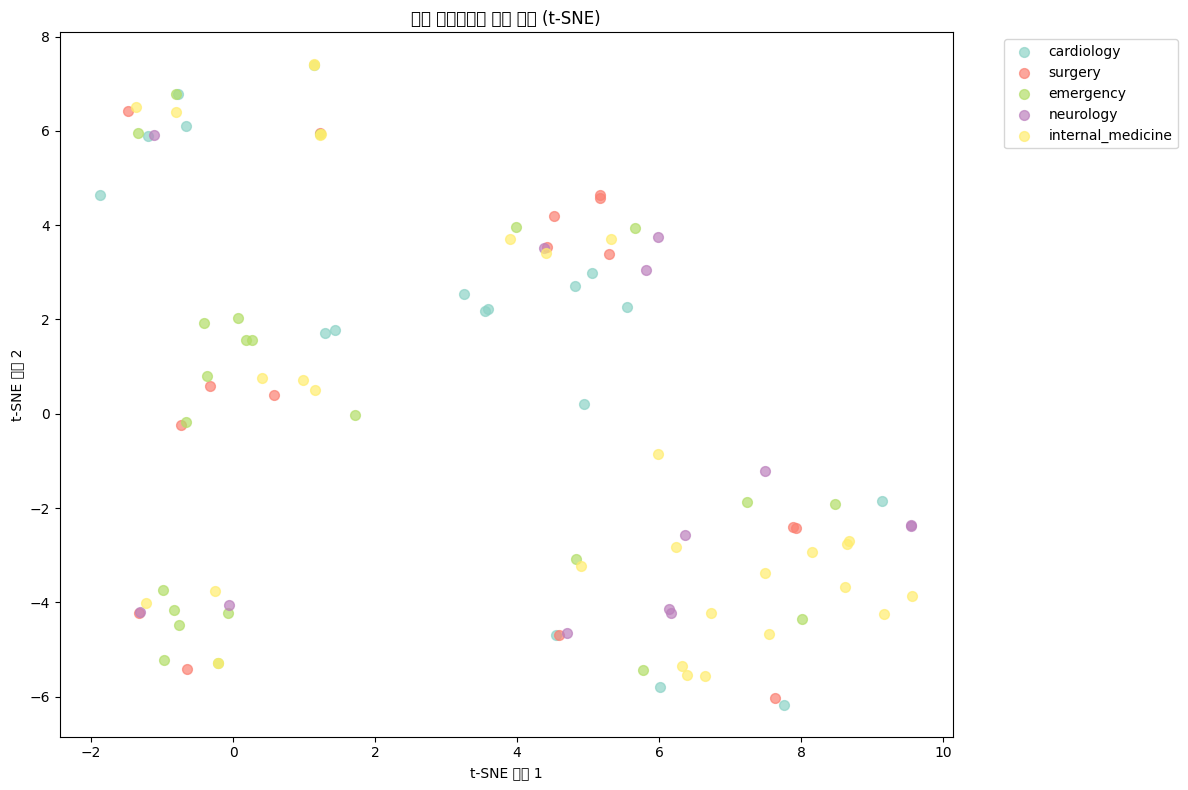

‚úÖ ÏãúÍ∞ÅÌôî ÏôÑÎ£å

üìã ÏµúÏ¢Ö Í≤ÄÏ¶ù Í≤∞Í≥º
Basic Info: ‚úÖ PASS
Metadata: ‚úÖ PASS
Search Quality: ‚úÖ PASS
Similarity: ‚úÖ PASS
Distribution: ‚úÖ PASS

üéØ Ï†ÑÏ≤¥ Ï†êÏàò: 100.0% (5/5)
üéâ Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥Í∞Ä ÏÑ±Í≥µÏ†ÅÏúºÎ°ú Íµ¨Ï∂ïÎêòÏóàÏäµÎãàÎã§!


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from collections import Counter
import seaborn as sns

class VectorStoreValidator:
    """
    Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥ Í≤ÄÏ¶ù Î∞è ÌÖåÏä§Ìä∏ ÌÅ¥ÎûòÏä§
    """
    
    def __init__(self, vector_store, vectorstore):
        self.vector_store = vector_store
        self.vectorstore = vectorstore
        
    def basic_info_check(self):
        """
        Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥ Í∏∞Î≥∏ Ï†ïÎ≥¥ ÌôïÏù∏
        """
        print("=" * 60)
        print("üîç Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥ Í∏∞Î≥∏ Ï†ïÎ≥¥ Í≤ÄÏ¶ù")
        print("=" * 60)
        
        try:
            # Î≤°ÌÑ∞ Í∞úÏàò ÌôïÏù∏
            total_vectors = self.vectorstore.index.ntotal
            print(f"‚úÖ Ï¥ù Î≤°ÌÑ∞ Í∞úÏàò: {total_vectors:,}Í∞ú")
            
            # Î≤°ÌÑ∞ Ï∞®Ïõê ÌôïÏù∏
            vector_dim = self.vectorstore.index.d
            print(f"‚úÖ Î≤°ÌÑ∞ Ï∞®Ïõê: {vector_dim}Ï∞®Ïõê")
            
            # Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ ÌôïÏù∏
            if hasattr(self.vectorstore, 'docstore'):
                doc_count = len(self.vectorstore.docstore._dict)
                print(f"‚úÖ Ï†ÄÏû•Îêú Î¨∏ÏÑú Ïàò: {doc_count:,}Í∞ú")
            
            # Ïù∏Îç±Ïä§ ÌÉÄÏûÖ ÌôïÏù∏
            index_type = type(self.vectorstore.index).__name__
            print(f"‚úÖ Ïù∏Îç±Ïä§ ÌÉÄÏûÖ: {index_type}")
            
            return True
            
        except Exception as e:
            print(f"‚ùå Í∏∞Î≥∏ Ï†ïÎ≥¥ ÌôïÏù∏ Ïã§Ìå®: {e}")
            return False
    
    def metadata_analysis(self):
        """
        Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ Î∂ÑÏÑù
        """
        print("\n" + "=" * 60)
        print("üìä Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ Î∂ÑÏÑù")
        print("=" * 60)
        
        try:
            if not hasattr(self.vectorstore, 'docstore'):
                print("‚ùå Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ Ï†ëÍ∑º Î∂àÍ∞Ä")
                return False
            
            # Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ ÏàòÏßë
            all_metadata = []
            for doc_id, doc in self.vectorstore.docstore._dict.items():
                if hasattr(doc, 'metadata'):
                    all_metadata.append(doc.metadata)
            
            print(f"‚úÖ Î©îÌÉÄÎç∞Ïù¥ÌÑ∞Í∞Ä ÏûàÎäî Î¨∏ÏÑú: {len(all_metadata)}Í∞ú")
            
            # ÏßÑÎ£åÍ≥ºÎ≥Ñ Î∂ÑÌè¨
            departments = [meta.get('department', 'Unknown') for meta in all_metadata]
            dept_counter = Counter(departments)
            print(f"\nüìã ÏßÑÎ£åÍ≥ºÎ≥Ñ Î¨∏ÏÑú Î∂ÑÌè¨:")
            for dept, count in dept_counter.most_common():
                print(f"  - {dept}: {count}Í∞ú")
            
            # Î¨∏ÏÑú ÌÉÄÏûÖÎ≥Ñ Î∂ÑÌè¨
            doc_types = [meta.get('document_type', 'Unknown') for meta in all_metadata]
            type_counter = Counter(doc_types)
            print(f"\nüìã Î¨∏ÏÑú ÌÉÄÏûÖÎ≥Ñ Î∂ÑÌè¨:")
            for doc_type, count in type_counter.most_common():
                print(f"  - {doc_type}: {count}Í∞ú")
            
            # ÏÑ±Î≥Ñ Î∂ÑÌè¨
            genders = [meta.get('gender', 'Unknown') for meta in all_metadata]
            gender_counter = Counter(genders)
            print(f"\nüìã ÏÑ±Î≥Ñ Î∂ÑÌè¨:")
            for gender, count in gender_counter.items():
                print(f"  - {gender}: {count}Í∞ú")
            
            return True
            
        except Exception as e:
            print(f"‚ùå Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ Î∂ÑÏÑù Ïã§Ìå®: {e}")
            return False
    
    def search_quality_test(self):
        """
        Í≤ÄÏÉâ ÌíàÏßà ÌÖåÏä§Ìä∏
        """
        print("\n" + "=" * 60)
        print("üîç Í≤ÄÏÉâ ÌíàÏßà ÌÖåÏä§Ìä∏")
        print("=" * 60)
        
        # Îã§ÏñëÌïú ÌÖåÏä§Ìä∏ ÏøºÎ¶¨
        test_queries = [
            ("ÎãπÎá®Î≥ë", "diabetes"),
            ("Í≥†ÌòàÏïï", "hypertension"),  
            ("Ïã¨Ïû•", "heart"),
            ("ÏàòÏà†", "surgery"),
            ("ÏïΩÎ¨º", "medication"),
            ("Í≤ÄÏÇ¨", "test"),
            ("ÏßÑÎã®", "diagnosis"),
            ("Ïó¨ÏÑ± ÌôòÏûê", "female patient"),
            ("ÏùëÍ∏âÏã§", "emergency"),
            ("ÎÇ¥Í≥º", "internal medicine")
        ]
        
        successful_searches = 0
        total_results = 0
        
        for korean_query, english_desc in test_queries:
            try:
                print(f"\nüîç ÌÖåÏä§Ìä∏ ÏøºÎ¶¨: '{korean_query}' ({english_desc})")
                
                # Í≤ÄÏÉâ Ïã§Ìñâ
                results = self.vector_store.search_similar_documents(
                    korean_query, 
                    self.vectorstore, 
                    k=3
                )
                
                if results:
                    print(f"‚úÖ Í≤ÄÏÉâ ÏÑ±Í≥µ: {len(results)}Í∞ú Í≤∞Í≥º")
                    successful_searches += 1
                    total_results += len(results)
                    
                    # Ï≤´ Î≤àÏß∏ Í≤∞Í≥º ÎØ∏Î¶¨Î≥¥Í∏∞
                    first_result = results[0]
                    print(f"   üë§ ÌôòÏûê: {first_result.metadata.get('name', 'N/A')}")
                    print(f"   üè• ÏßÑÎ£åÍ≥º: {first_result.metadata.get('department', 'N/A')}")
                    print(f"   üìÑ Î¨∏ÏÑúÌÉÄÏûÖ: {first_result.metadata.get('document_type', 'N/A')}")
                    print(f"   üìù ÎÇ¥Ïö©: {first_result.page_content[:100]}...")
                else:
                    print(f"‚ùå Í≤ÄÏÉâ Ïã§Ìå®: Í≤∞Í≥º ÏóÜÏùå")
                    
            except Exception as e:
                print(f"‚ùå Í≤ÄÏÉâ Ïò§Î•ò: {e}")
        
        success_rate = (successful_searches / len(test_queries)) * 100
        avg_results = total_results / successful_searches if successful_searches > 0 else 0
        
        print(f"\nüìä Í≤ÄÏÉâ ÏÑ±Îä• ÏöîÏïΩ:")
        print(f"   ÏÑ±Í≥µÎ•†: {success_rate:.1f}% ({successful_searches}/{len(test_queries)})")
        print(f"   ÌèâÍ∑† Í≤∞Í≥º Ïàò: {avg_results:.1f}Í∞ú")
        
        return success_rate >= 80  # 80% Ïù¥ÏÉÅ ÏÑ±Í≥µÌïòÎ©¥ PASS
    
    def similarity_test(self):
        """
        Ïú†ÏÇ¨ÎèÑ ÌíàÏßà ÌÖåÏä§Ìä∏
        """
        print("\n" + "=" * 60)
        print("üìè Ïú†ÏÇ¨ÎèÑ ÌíàÏßà ÌÖåÏä§Ìä∏")
        print("=" * 60)
        
        try:
            # Í¥ÄÎ†®ÏÑ±Ïù¥ ÎÜíÏùÄ ÏøºÎ¶¨ ÏåçÎì§Î°ú ÌÖåÏä§Ìä∏
            related_pairs = [
                # 1. ÎãπÎá®Î≥ë Í¥ÄÎ†® Ïåç
                ("ÎãπÎá®Î≥ë", "ÌòàÎãπÏù¥ ÎÜíÏùÄ ÌôòÏûê"),
                ("ÎãπÎá®Î≥ë", "Ïù∏ÏäêÎ¶∞ ÏπòÎ£å"),
                ("Ï†ú2Ìòï ÎãπÎá®Î≥ë", "ÌòàÎãπ Ï°∞Ï†à"),
                
                # 2. Í≥†ÌòàÏïï Í¥ÄÎ†® Ïåç  
                ("Í≥†ÌòàÏïï", "ÌòàÏïïÏù¥ ÎÜíÏùÄ ÌôòÏûê"),
                ("Í≥†ÌòàÏïï", "ÌòàÏïïÏïΩ"),
                ("Í≥†ÌòàÏïï", "ÏàòÏ∂ïÍ∏∞ ÌòàÏïï"),
                
                # 3. Ïã¨Ïû•ÏßàÌôò Í¥ÄÎ†® Ïåç
                ("Ïã¨Ïû•Î≥ë", "Ïã¨Í∑ºÍ≤ΩÏÉâ"),
                ("Ïã¨Ïû•Î≥ë", "ÌùâÌÜµ"),
                ("Î∂ÄÏ†ïÎß•", "Ïã¨Ï†ÑÎèÑ"),
                ("ÌòëÏã¨Ï¶ù", "Í∞ÄÏä¥ ÌÜµÏ¶ù"),
                
                # 4. Ìò∏Ìù°Í∏∞ Í¥ÄÎ†® Ïåç
                ("ÌèêÎ†¥", "Í∏∞Ïπ®"),
                ("Ï≤úÏãù", "Ìò∏Ìù°Í≥§ÎûÄ"),
                ("ÌèêÎ†¥", "Î∞úÏó¥"),
                
                # 5. ÏÜåÌôîÍ∏∞ Í¥ÄÎ†® Ïåç
                ("ÏúÑÏóº", "Î≥µÌÜµ"),
                ("ÏúÑÍ∂§Ïñë", "ÏÜç Ïì∞Î¶º"),
                ("Í∞ÑÏóº", "Í∞Ñ Í∏∞Îä• Í≤ÄÏÇ¨"),
                
                # 6. Ïã†Í≤ΩÍ≥Ñ Í¥ÄÎ†® Ïåç
                ("ÎáåÏ°∏Ï§ë", "ÎßàÎπÑ Ï¶ùÏÉÅ"),
                ("ÎëêÌÜµ", "Ìé∏ÎëêÌÜµ"),
                ("ÏπòÎß§", "Í∏∞ÏñµÎ†• Ï†ÄÌïò"),
                
                # 7. Í≤ÄÏÇ¨ Í¥ÄÎ†® Ïåç
                ("ÌòàÏï°Í≤ÄÏÇ¨", "CBC"),
                ("ÏòÅÏÉÅÍ≤ÄÏÇ¨", "CT Ï¥¨ÏòÅ"),
                ("Ïã¨Ï†ÑÎèÑ", "EKG"),
                
                # 8. ÏπòÎ£å Í¥ÄÎ†® Ïåç
                ("ÏàòÏà†", "Ï†ÑÏã†ÎßàÏ∑®"),
                ("ÏïΩÎ¨ºÏπòÎ£å", "Ï≤òÎ∞©Ï†Ñ"),
                ("Î¨ºÎ¶¨ÏπòÎ£å", "Ïû¨Ìôú"),
                
                # 9. Ï¶ùÏÉÅ Í¥ÄÎ†® Ïåç
                ("Î∞úÏó¥", "Ï≤¥Ïò® ÏÉÅÏäπ"),
                ("Ïñ¥ÏßÄÎü¨ÏõÄ", "ÌòÑÍ∏∞Ï¶ù"),
                ("Íµ¨ÌÜ†", "Î©îÏä§Í∫ºÏõÄ"),
                
                # 10. ÏùëÍ∏âÏÉÅÌô© Í¥ÄÎ†® Ïåç
                ("ÏùëÍ∏âÏã§", "ÏùëÍ∏âÌôòÏûê"),
                ("ÏáºÌÅ¨", "ÌòàÏïï Ï†ÄÌïò"),
                ("Ïã¨Ï†ïÏßÄ", "Ïã¨ÌèêÏÜåÏÉùÏà†")
            ]
            
            similarity_scores = []
            
            for query1, query2 in related_pairs:
                print(f"\nüîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: '{query1}' vs '{query2}'")
                
                # Í∞ÅÍ∞Å Í≤ÄÏÉâ
                results1 = self.vector_store.search_similar_documents(query1, self.vectorstore, k=5)
                results2 = self.vector_store.search_similar_documents(query2, self.vectorstore, k=5)
                
                if results1 and results2:
                    # Í≤∞Í≥º Î¨∏ÏÑúÎì§Ïùò ÌôòÏûê ID ÎπÑÍµê
                    patients1 = set(doc.metadata.get('patient_id') for doc in results1)
                    patients2 = set(doc.metadata.get('patient_id') for doc in results2)
                    
                    # ÍµêÏßëÌï© ÎπÑÏú® Í≥ÑÏÇ∞ (Í¥ÄÎ†®ÏÑ± ÏßÄÌëú)
                    overlap = len(patients1.intersection(patients2))
                    total_unique = len(patients1.union(patients2))
                    similarity = overlap / total_unique if total_unique > 0 else 0
                    
                    similarity_scores.append(similarity)
                    print(f"   üìä ÌôòÏûê Í≤πÏπ®Î•†: {similarity:.2%} ({overlap}/{total_unique})")
                else:
                    print(f"   ‚ùå Í≤ÄÏÉâ Ïã§Ìå®")
            
            if similarity_scores:
                avg_similarity = np.mean(similarity_scores)
                print(f"\nüìä ÌèâÍ∑† Ïó∞Í¥ÄÏÑ± Ï†êÏàò: {avg_similarity:.2%}")
                return avg_similarity >= 0.1  # 10% Ïù¥ÏÉÅ Í≤πÏπòÎ©¥ PASS
            else:
                return False
                
        except Exception as e:
            print(f"‚ùå Ïú†ÏÇ¨ÎèÑ ÌÖåÏä§Ìä∏ Ïã§Ìå®: {e}")
            return False
    
    def vector_distribution_analysis(self, sample_size=100):
        """
        Î≤°ÌÑ∞ Î∂ÑÌè¨ Î∂ÑÏÑù (ÏãúÍ∞ÅÌôî)
        """
        print("\n" + "=" * 60)
        print("üìà Î≤°ÌÑ∞ Î∂ÑÌè¨ Î∂ÑÏÑù")
        print("=" * 60)
        
        try:
            # ÏÉòÌîå Î≤°ÌÑ∞ Ï∂îÏ∂ú
            total_vectors = self.vectorstore.index.ntotal
            sample_indices = np.random.choice(
                total_vectors, 
                min(sample_size, total_vectors), 
                replace=False
            )
            
            # Î≤°ÌÑ∞ Îç∞Ïù¥ÌÑ∞ Ï∂îÏ∂ú
            sample_vectors = []
            sample_metadata = []
            
            for idx in sample_indices:
                vector = self.vectorstore.index.reconstruct(int(idx))
                sample_vectors.append(vector)
                
                # Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ Í∞ÄÏ†∏Ïò§Í∏∞
                if hasattr(self.vectorstore, 'docstore'):
                    doc_id = list(self.vectorstore.docstore._dict.keys())[idx]
                    doc = self.vectorstore.docstore._dict[doc_id]
                    if hasattr(doc, 'metadata'):
                        sample_metadata.append(doc.metadata)
                    else:
                        sample_metadata.append({})
                else:
                    sample_metadata.append({})
            
            sample_vectors = np.array(sample_vectors)
            print(f"‚úÖ {len(sample_vectors)}Í∞ú Î≤°ÌÑ∞ ÏÉòÌîå Ï∂îÏ∂ú")
            
            # Í∏∞Î≥∏ ÌÜµÍ≥Ñ
            print(f"üìä Î≤°ÌÑ∞ ÌÜµÍ≥Ñ:")
            print(f"   ÌèâÍ∑† ÌÅ¨Í∏∞: {np.mean(np.linalg.norm(sample_vectors, axis=1)):.4f}")
            print(f"   ÌëúÏ§ÄÌé∏Ï∞®: {np.std(np.linalg.norm(sample_vectors, axis=1)):.4f}")
            print(f"   ÏµúÏÜåÍ∞í: {np.min(sample_vectors):.4f}")
            print(f"   ÏµúÎåÄÍ∞í: {np.max(sample_vectors):.4f}")
            
            # t-SNEÎ°ú 2D ÏãúÍ∞ÅÌôî
            if len(sample_vectors) >= 10:
                print("\nüé® t-SNE ÏãúÍ∞ÅÌôî ÏÉùÏÑ± Ï§ë...")
                tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(sample_vectors)-1))
                vectors_2d = tsne.fit_transform(sample_vectors)
                
                # ÏßÑÎ£åÍ≥ºÎ≥Ñ ÏÉâÏÉÅ Îß§Ìïë
                departments = [meta.get('department', 'Unknown') for meta in sample_metadata]
                unique_depts = list(set(departments))
                colors = plt.cm.Set3(np.linspace(0, 1, len(unique_depts)))
                dept_color_map = dict(zip(unique_depts, colors))
                
                plt.figure(figsize=(12, 8))
                
                for dept in unique_depts:
                    dept_indices = [i for i, d in enumerate(departments) if d == dept]
                    if dept_indices:
                        plt.scatter(
                            vectors_2d[dept_indices, 0], 
                            vectors_2d[dept_indices, 1],
                            c=[dept_color_map[dept]], 
                            label=dept, 
                            alpha=0.7,
                            s=50
                        )
                
                plt.title('Î≤°ÌÑ∞ Í≥µÍ∞ÑÏóêÏÑúÏùò Î¨∏ÏÑú Î∂ÑÌè¨ (t-SNE)')
                plt.xlabel('t-SNE Ï∞®Ïõê 1')
                plt.ylabel('t-SNE Ï∞®Ïõê 2')
                plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
                plt.tight_layout()
                plt.show()
                
                print("‚úÖ ÏãúÍ∞ÅÌôî ÏôÑÎ£å")
            
            return True
            
        except Exception as e:
            print(f"‚ùå Î≤°ÌÑ∞ Î∂ÑÌè¨ Î∂ÑÏÑù Ïã§Ìå®: {e}")
            import traceback
            print(traceback.format_exc())
            return False
    
    def comprehensive_validation(self):
        """
        Ï¢ÖÌï© Í≤ÄÏ¶ù Ïã§Ìñâ
        """
        print("üöÄ Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥ Ï¢ÖÌï© Í≤ÄÏ¶ù ÏãúÏûë")
        print("=" * 80)
        
        results = {
            'basic_info': self.basic_info_check(),
            'metadata': self.metadata_analysis(),
            'search_quality': self.search_quality_test(),
            'similarity': self.similarity_test(),
            'distribution': self.vector_distribution_analysis()
        }
        
        print("\n" + "=" * 80)
        print("üìã ÏµúÏ¢Ö Í≤ÄÏ¶ù Í≤∞Í≥º")
        print("=" * 80)
        
        passed_tests = 0
        total_tests = len(results)
        
        for test_name, result in results.items():
            status = "‚úÖ PASS" if result else "‚ùå FAIL"
            print(f"{test_name.replace('_', ' ').title()}: {status}")
            if result:
                passed_tests += 1
        
        overall_score = (passed_tests / total_tests) * 100
        print(f"\nüéØ Ï†ÑÏ≤¥ Ï†êÏàò: {overall_score:.1f}% ({passed_tests}/{total_tests})")
        
        if overall_score >= 80:
            print("üéâ Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥Í∞Ä ÏÑ±Í≥µÏ†ÅÏúºÎ°ú Íµ¨Ï∂ïÎêòÏóàÏäµÎãàÎã§!")
        elif overall_score >= 60:
            print("‚ö†Ô∏è  Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥Í∞Ä Íµ¨Ï∂ïÎêòÏóàÏßÄÎßå ÏùºÎ∂Ä Í∞úÏÑ†Ïù¥ ÌïÑÏöîÌï©ÎãàÎã§.")
        else:
            print("‚ùå Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥Ïóê Ïã¨Í∞ÅÌïú Î¨∏Ï†úÍ∞Ä ÏûàÏäµÎãàÎã§. Ïû¨Íµ¨Ï∂ïÏùÑ Í∂åÏû•Ìï©ÎãàÎã§.")
        
        return overall_score >= 60

# ÏÇ¨Ïö© ÏòàÏãú
if __name__ == "__main__":
    # Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥ Í≤ÄÏ¶ù Ïã§Ìñâ
    validator = VectorStoreValidator(vector_store, vectorstore)
    validator.comprehensive_validation()

# Í≤ÄÏ¶ù2 unified

2025-05-25 00:22:23,045 - INFO - Using device: cpu
2025-05-25 00:22:23,046 - INFO - multilingual-e5-large Î™®Îç∏ Î°úÎìú Ï§ë...
2025-05-25 00:22:23,048 - INFO - Load pretrained SentenceTransformer: intfloat/multilingual-e5-large
2025-05-25 00:22:26,955 - INFO - ÏûÑÎ≤†Îî© Î™®Îç∏ Î°úÎìú ÏôÑÎ£å
2025-05-25 00:22:26,956 - INFO - vector_stores\medical_vector_store_e5_unifiedÏóêÏÑú Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥ Î°úÎìú Ï§ë...
2025-05-25 00:22:27,024 - WARNING - `embedding_function` is expected to be an Embeddings object, support for passing in a function will soon be removed.
2025-05-25 00:22:27,024 - INFO - Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥ Î°úÎìú ÏôÑÎ£å
2025-05-25 00:22:27,028 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÎãπÎá®Î≥ë' (ÏÉÅÏúÑ 3Í∞ú Í≤∞Í≥º)


‚úÖ Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥ Î°úÎìú ÏôÑÎ£å!
üöÄ Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥ Ï¢ÖÌï© Í≤ÄÏ¶ù ÏãúÏûë
üîç Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥ Í∏∞Î≥∏ Ï†ïÎ≥¥ Í≤ÄÏ¶ù
‚úÖ Ï¥ù Î≤°ÌÑ∞ Í∞úÏàò: 5,196Í∞ú
‚úÖ Î≤°ÌÑ∞ Ï∞®Ïõê: 1024Ï∞®Ïõê
‚úÖ Ï†ÄÏû•Îêú Î¨∏ÏÑú Ïàò: 5,196Í∞ú
‚úÖ Ïù∏Îç±Ïä§ ÌÉÄÏûÖ: IndexFlatL2

üìä Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ Î∂ÑÏÑù
‚úÖ Î©îÌÉÄÎç∞Ïù¥ÌÑ∞Í∞Ä ÏûàÎäî Î¨∏ÏÑú: 5196Í∞ú

üìã ÏßÑÎ£åÍ≥ºÎ≥Ñ Î¨∏ÏÑú Î∂ÑÌè¨:
  - internal_medicine: 1501Í∞ú
  - emergency: 1231Í∞ú
  - surgery: 999Í∞ú
  - cardiology: 832Í∞ú
  - neurology: 633Í∞ú

üìã Î¨∏ÏÑú ÌÉÄÏûÖÎ≥Ñ Î∂ÑÌè¨:
  - visit: 2796Í∞ú
  - lab_result: 1188Í∞ú
  - integrated_record: 275Í∞ú
  - imaging_study: 273Í∞ú
  - diagnosis: 223Í∞ú
  - procedure: 178Í∞ú
  - basic_info: 165Í∞ú
  - medication: 98Í∞ú

üìã ÏÑ±Î≥Ñ Î∂ÑÌè¨:
  - ÎÇ®: 2317Í∞ú
  - Ïó¨: 2879Í∞ú

üîç Í≤ÄÏÉâ ÌíàÏßà ÌÖåÏä§Ìä∏

üîç ÌÖåÏä§Ìä∏ ÏøºÎ¶¨: 'ÎãπÎá®Î≥ë' (diabetes)


2025-05-25 00:22:28,173 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 3Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:28,174 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Í≥†ÌòàÏïï' (ÏÉÅÏúÑ 3Í∞ú Í≤∞Í≥º)


‚úÖ Í≤ÄÏÉâ ÏÑ±Í≥µ: 3Í∞ú Í≤∞Í≥º
   üë§ ÌôòÏûê: ÍπÄÎ∞îÎèå
   üè• ÏßÑÎ£åÍ≥º: internal_medicine
   üìÑ Î¨∏ÏÑúÌÉÄÏûÖ: diagnosis
   üìù ÎÇ¥Ïö©: ÌôòÏûê ID: I16626
                Ïù¥Î¶Ñ: ÍπÄÎ∞îÎèå
                ÏÑ±Î≥Ñ: ÎÇ®
                ÎÇòÏù¥: 49

                ...

üîç ÌÖåÏä§Ìä∏ ÏøºÎ¶¨: 'Í≥†ÌòàÏïï' (hypertension)


2025-05-25 00:22:28,387 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 3Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:28,388 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Ïã¨Ïû•' (ÏÉÅÏúÑ 3Í∞ú Í≤∞Í≥º)
2025-05-25 00:22:28,564 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 3Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:28,565 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÏàòÏà†' (ÏÉÅÏúÑ 3Í∞ú Í≤∞Í≥º)


‚úÖ Í≤ÄÏÉâ ÏÑ±Í≥µ: 3Í∞ú Í≤∞Í≥º
   üë§ ÌôòÏûê: Ïù¥ÏûêÎØ∏
   üè• ÏßÑÎ£åÍ≥º: internal_medicine
   üìÑ Î¨∏ÏÑúÌÉÄÏûÖ: diagnosis
   üìù ÎÇ¥Ïö©: ÌôòÏûê ID: I65633
                Ïù¥Î¶Ñ: Ïù¥ÏûêÎØ∏
                ÏÑ±Î≥Ñ: Ïó¨
                ÎÇòÏù¥: 68

                ...

üîç ÌÖåÏä§Ìä∏ ÏøºÎ¶¨: 'Ïã¨Ïû•' (heart)
‚úÖ Í≤ÄÏÉâ ÏÑ±Í≥µ: 3Í∞ú Í≤∞Í≥º
   üë§ ÌôòÏûê: Ïù¥ÌååÎØ∏
   üè• ÏßÑÎ£åÍ≥º: cardiology
   üìÑ Î¨∏ÏÑúÌÉÄÏûÖ: diagnosis
   üìù ÎÇ¥Ïö©: ÌôòÏûê ID: C24696
                Ïù¥Î¶Ñ: Ïù¥ÌååÎØ∏
                ÏÑ±Î≥Ñ: Ïó¨
                ÎÇòÏù¥: 67

                ...

üîç ÌÖåÏä§Ìä∏ ÏøºÎ¶¨: 'ÏàòÏà†' (surgery)


2025-05-25 00:22:28,740 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 3Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:28,741 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÏïΩÎ¨º' (ÏÉÅÏúÑ 3Í∞ú Í≤∞Í≥º)
2025-05-25 00:22:28,930 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 3Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨


‚úÖ Í≤ÄÏÉâ ÏÑ±Í≥µ: 3Í∞ú Í≤∞Í≥º
   üë§ ÌôòÏûê: ÍπÄÎ∞îÎèå
   üè• ÏßÑÎ£åÍ≥º: internal_medicine
   üìÑ Î¨∏ÏÑúÌÉÄÏûÖ: procedure
   üìù ÎÇ¥Ïö©: ÌôòÏûê ID: I16626
                Ïù¥Î¶Ñ: ÍπÄÎ∞îÎèå
                ÏÑ±Î≥Ñ: ÎÇ®
                ÎÇòÏù¥: 49

                ...

üîç ÌÖåÏä§Ìä∏ ÏøºÎ¶¨: 'ÏïΩÎ¨º' (medication)


2025-05-25 00:22:28,932 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Í≤ÄÏÇ¨' (ÏÉÅÏúÑ 3Í∞ú Í≤∞Í≥º)
2025-05-25 00:22:29,120 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 3Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨


‚úÖ Í≤ÄÏÉâ ÏÑ±Í≥µ: 3Í∞ú Í≤∞Í≥º
   üë§ ÌôòÏûê: ÍπÄÌååÎèå
   üè• ÏßÑÎ£åÍ≥º: emergency
   üìÑ Î¨∏ÏÑúÌÉÄÏûÖ: diagnosis
   üìù ÎÇ¥Ïö©: ÌôòÏûê ID: E36456
                Ïù¥Î¶Ñ: ÍπÄÌååÎèå
                ÏÑ±Î≥Ñ: ÎÇ®
                ÎÇòÏù¥: 11

                ...

üîç ÌÖåÏä§Ìä∏ ÏøºÎ¶¨: 'Í≤ÄÏÇ¨' (test)


2025-05-25 00:22:29,121 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÏßÑÎã®' (ÏÉÅÏúÑ 3Í∞ú Í≤∞Í≥º)
2025-05-25 00:22:29,292 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 3Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:29,293 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Ïó¨ÏÑ± ÌôòÏûê' (ÏÉÅÏúÑ 3Í∞ú Í≤∞Í≥º)


‚úÖ Í≤ÄÏÉâ ÏÑ±Í≥µ: 3Í∞ú Í≤∞Í≥º
   üë§ ÌôòÏûê: ÍπÄÎßàÎèå
   üè• ÏßÑÎ£åÍ≥º: cardiology
   üìÑ Î¨∏ÏÑúÌÉÄÏûÖ: lab_result
   üìù ÎÇ¥Ïö©: Ìï¥ÏÑù: Î™®Îì† Í≤ÄÏÇ¨ Í≤∞Í≥ºÍ∞Ä Ï†ïÏÉÅ Î≤îÏúÑ ÎÇ¥Ïóê ÏûàÏäµÎãàÎã§....

üîç ÌÖåÏä§Ìä∏ ÏøºÎ¶¨: 'ÏßÑÎã®' (diagnosis)
‚úÖ Í≤ÄÏÉâ ÏÑ±Í≥µ: 3Í∞ú Í≤∞Í≥º
   üë§ ÌôòÏûê: ÍπÄÎ∞îÎèå
   üè• ÏßÑÎ£åÍ≥º: surgery
   üìÑ Î¨∏ÏÑúÌÉÄÏûÖ: diagnosis
   üìù ÎÇ¥Ïö©: ÌôòÏûê ID: S20491
                Ïù¥Î¶Ñ: ÍπÄÎ∞îÎèå
                ÏÑ±Î≥Ñ: ÎÇ®
                ÎÇòÏù¥: 65

                ...

üîç ÌÖåÏä§Ìä∏ ÏøºÎ¶¨: 'Ïó¨ÏÑ± ÌôòÏûê' (female patient)


2025-05-25 00:22:29,478 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 3Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:29,479 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÏùëÍ∏âÏã§' (ÏÉÅÏúÑ 3Í∞ú Í≤∞Í≥º)
2025-05-25 00:22:29,677 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 3Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨


‚úÖ Í≤ÄÏÉâ ÏÑ±Í≥µ: 3Í∞ú Í≤∞Í≥º
   üë§ ÌôòÏûê: Ïù¥Î∞îÎØ∏
   üè• ÏßÑÎ£åÍ≥º: emergency
   üìÑ Î¨∏ÏÑúÌÉÄÏûÖ: visit
   üìù ÎÇ¥Ïö©: ÌôòÏûê ID: E57017
                Ïù¥Î¶Ñ: Ïù¥Î∞îÎØ∏
                ÏÑ±Î≥Ñ: Ïó¨
                ÎÇòÏù¥: 36

                ...

üîç ÌÖåÏä§Ìä∏ ÏøºÎ¶¨: 'ÏùëÍ∏âÏã§' (emergency)


2025-05-25 00:22:29,678 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÎÇ¥Í≥º' (ÏÉÅÏúÑ 3Í∞ú Í≤∞Í≥º)
2025-05-25 00:22:29,855 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 3Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:29,856 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÎãπÎá®Î≥ë' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)


‚úÖ Í≤ÄÏÉâ ÏÑ±Í≥µ: 3Í∞ú Í≤∞Í≥º
   üë§ ÌôòÏûê: ÍπÄÍ∞ÄÎèå
   üè• ÏßÑÎ£åÍ≥º: emergency
   üìÑ Î¨∏ÏÑúÌÉÄÏûÖ: visit
   üìù ÎÇ¥Ïö©: ÌôòÏûê ID: E11422
                Ïù¥Î¶Ñ: ÍπÄÍ∞ÄÎèå
                ÏÑ±Î≥Ñ: ÎÇ®
                ÎÇòÏù¥: 27

                ...

üîç ÌÖåÏä§Ìä∏ ÏøºÎ¶¨: 'ÎÇ¥Í≥º' (internal medicine)
‚úÖ Í≤ÄÏÉâ ÏÑ±Í≥µ: 3Í∞ú Í≤∞Í≥º
   üë§ ÌôòÏûê: Ïù¥ÎÇòÎØ∏
   üè• ÏßÑÎ£åÍ≥º: internal_medicine
   üìÑ Î¨∏ÏÑúÌÉÄÏûÖ: procedure
   üìù ÎÇ¥Ïö©: ÌôòÏûê ID: I12953
                Ïù¥Î¶Ñ: Ïù¥ÎÇòÎØ∏
                ÏÑ±Î≥Ñ: Ïó¨
                ÎÇòÏù¥: 43

                ...

üìä Í≤ÄÏÉâ ÏÑ±Îä• ÏöîÏïΩ:
   ÏÑ±Í≥µÎ•†: 100.0% (10/10)
   ÌèâÍ∑† Í≤∞Í≥º Ïàò: 3.0Í∞ú

üìè Ïú†ÏÇ¨ÎèÑ ÌíàÏßà ÌÖåÏä§Ìä∏

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'ÎãπÎá®Î≥ë' vs 'ÌòàÎãπÏù¥ ÎÜíÏùÄ ÌôòÏûê'


2025-05-25 00:22:30,029 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:30,030 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÌòàÎãπÏù¥ ÎÜíÏùÄ ÌôòÏûê' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-25 00:22:30,210 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:30,211 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÎãπÎá®Î≥ë' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-25 00:22:30,393 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 0.00% (0/9)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'ÎãπÎá®Î≥ë' vs 'Ïù∏ÏäêÎ¶∞ ÏπòÎ£å'


2025-05-25 00:22:30,394 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Ïù∏ÏäêÎ¶∞ ÏπòÎ£å' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-25 00:22:30,586 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:30,587 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Ï†ú2Ìòï ÎãπÎá®Î≥ë' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-25 00:22:30,767 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 50.00% (3/6)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'Ï†ú2Ìòï ÎãπÎá®Î≥ë' vs 'ÌòàÎãπ Ï°∞Ï†à'


2025-05-25 00:22:30,768 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÌòàÎãπ Ï°∞Ï†à' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-25 00:22:30,946 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:30,947 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Í≥†ÌòàÏïï' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-25 00:22:31,143 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 0.00% (0/9)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'Í≥†ÌòàÏïï' vs 'ÌòàÏïïÏù¥ ÎÜíÏùÄ ÌôòÏûê'


2025-05-25 00:22:31,144 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÌòàÏïïÏù¥ ÎÜíÏùÄ ÌôòÏûê' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-25 00:22:31,352 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:31,353 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Í≥†ÌòàÏïï' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 80.00% (4/5)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'Í≥†ÌòàÏïï' vs 'ÌòàÏïïÏïΩ'


2025-05-25 00:22:31,607 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:31,609 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÌòàÏïïÏïΩ' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-25 00:22:31,791 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:31,792 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Í≥†ÌòàÏïï' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-25 00:22:31,983 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 28.57% (2/7)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'Í≥†ÌòàÏïï' vs 'ÏàòÏ∂ïÍ∏∞ ÌòàÏïï'


2025-05-25 00:22:31,984 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÏàòÏ∂ïÍ∏∞ ÌòàÏïï' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-25 00:22:32,174 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:32,175 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Ïã¨Ïû•Î≥ë' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-25 00:22:32,365 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 14.29% (1/7)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'Ïã¨Ïû•Î≥ë' vs 'Ïã¨Í∑ºÍ≤ΩÏÉâ'


2025-05-25 00:22:32,366 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Ïã¨Í∑ºÍ≤ΩÏÉâ' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-25 00:22:32,546 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:32,547 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Ïã¨Ïû•Î≥ë' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-25 00:22:32,730 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:32,731 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÌùâÌÜµ' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 50.00% (3/6)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'Ïã¨Ïû•Î≥ë' vs 'ÌùâÌÜµ'


2025-05-25 00:22:32,925 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:32,926 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Î∂ÄÏ†ïÎß•' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-25 00:22:33,090 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:33,091 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Ïã¨Ï†ÑÎèÑ' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 0.00% (0/9)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'Î∂ÄÏ†ïÎß•' vs 'Ïã¨Ï†ÑÎèÑ'


2025-05-25 00:22:33,267 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:33,268 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÌòëÏã¨Ï¶ù' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-25 00:22:33,429 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:33,430 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Í∞ÄÏä¥ ÌÜµÏ¶ù' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 0.00% (0/9)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'ÌòëÏã¨Ï¶ù' vs 'Í∞ÄÏä¥ ÌÜµÏ¶ù'


2025-05-25 00:22:33,615 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:33,616 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÌèêÎ†¥' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-25 00:22:33,787 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:33,787 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Í∏∞Ïπ®' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 0.00% (0/10)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'ÌèêÎ†¥' vs 'Í∏∞Ïπ®'


2025-05-25 00:22:33,960 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:33,961 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Ï≤úÏãù' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-25 00:22:34,125 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:34,126 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Ìò∏Ìù°Í≥§ÎûÄ' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 11.11% (1/9)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'Ï≤úÏãù' vs 'Ìò∏Ìù°Í≥§ÎûÄ'


2025-05-25 00:22:34,294 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:34,295 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÌèêÎ†¥' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-25 00:22:34,460 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:34,461 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Î∞úÏó¥' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 0.00% (0/10)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'ÌèêÎ†¥' vs 'Î∞úÏó¥'


2025-05-25 00:22:34,624 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:34,625 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÏúÑÏóº' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-25 00:22:34,794 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:34,794 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Î≥µÌÜµ' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 0.00% (0/10)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'ÏúÑÏóº' vs 'Î≥µÌÜµ'


2025-05-25 00:22:34,970 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:34,971 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÏúÑÍ∂§Ïñë' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-25 00:22:35,161 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 11.11% (1/9)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'ÏúÑÍ∂§Ïñë' vs 'ÏÜç Ïì∞Î¶º'


2025-05-25 00:22:35,162 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÏÜç Ïì∞Î¶º' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-25 00:22:35,361 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:35,361 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Í∞ÑÏóº' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-25 00:22:35,539 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:35,539 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Í∞Ñ Í∏∞Îä• Í≤ÄÏÇ¨' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 0.00% (0/10)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'Í∞ÑÏóº' vs 'Í∞Ñ Í∏∞Îä• Í≤ÄÏÇ¨'


2025-05-25 00:22:35,736 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:35,737 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÎáåÏ°∏Ï§ë' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-25 00:22:35,930 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 0.00% (0/9)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'ÎáåÏ°∏Ï§ë' vs 'ÎßàÎπÑ Ï¶ùÏÉÅ'


2025-05-25 00:22:35,931 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÎßàÎπÑ Ï¶ùÏÉÅ' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-25 00:22:36,122 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:36,123 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÎëêÌÜµ' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-25 00:22:36,298 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:36,299 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Ìé∏ÎëêÌÜµ' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 25.00% (2/8)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'ÎëêÌÜµ' vs 'Ìé∏ÎëêÌÜµ'


2025-05-25 00:22:36,488 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:36,489 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÏπòÎß§' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-25 00:22:36,659 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:36,659 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Í∏∞ÏñµÎ†• Ï†ÄÌïò' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 14.29% (1/7)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'ÏπòÎß§' vs 'Í∏∞ÏñµÎ†• Ï†ÄÌïò'


2025-05-25 00:22:36,837 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:36,838 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÌòàÏï°Í≤ÄÏÇ¨' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 28.57% (2/7)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'ÌòàÏï°Í≤ÄÏÇ¨' vs 'CBC'


2025-05-25 00:22:37,064 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:37,065 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'CBC' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-25 00:22:37,267 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:37,268 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÏòÅÏÉÅÍ≤ÄÏÇ¨' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-25 00:22:37,448 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:37,449 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'CT Ï¥¨ÏòÅ' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 0.00% (0/8)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'ÏòÅÏÉÅÍ≤ÄÏÇ¨' vs 'CT Ï¥¨ÏòÅ'


2025-05-25 00:22:37,627 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:37,627 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Ïã¨Ï†ÑÎèÑ' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-25 00:22:37,811 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 0.00% (0/10)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'Ïã¨Ï†ÑÎèÑ' vs 'EKG'


2025-05-25 00:22:37,812 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'EKG' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-25 00:22:37,982 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:37,982 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÏàòÏà†' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-25 00:22:38,144 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:38,145 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Ï†ÑÏã†ÎßàÏ∑®' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 0.00% (0/9)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'ÏàòÏà†' vs 'Ï†ÑÏã†ÎßàÏ∑®'


2025-05-25 00:22:38,312 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:38,313 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÏïΩÎ¨ºÏπòÎ£å' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-25 00:22:38,494 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:38,495 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Ï≤òÎ∞©Ï†Ñ' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 0.00% (0/10)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'ÏïΩÎ¨ºÏπòÎ£å' vs 'Ï≤òÎ∞©Ï†Ñ'


2025-05-25 00:22:38,676 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:38,677 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Î¨ºÎ¶¨ÏπòÎ£å' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-25 00:22:38,838 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:38,839 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Ïû¨Ìôú' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 11.11% (1/9)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'Î¨ºÎ¶¨ÏπòÎ£å' vs 'Ïû¨Ìôú'


2025-05-25 00:22:39,010 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:39,010 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Î∞úÏó¥' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-25 00:22:39,193 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 11.11% (1/9)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'Î∞úÏó¥' vs 'Ï≤¥Ïò® ÏÉÅÏäπ'


2025-05-25 00:22:39,194 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Ï≤¥Ïò® ÏÉÅÏäπ' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-25 00:22:39,372 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:39,373 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Ïñ¥ÏßÄÎü¨ÏõÄ' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-25 00:22:39,546 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:39,547 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÌòÑÍ∏∞Ï¶ù' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 11.11% (1/9)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'Ïñ¥ÏßÄÎü¨ÏõÄ' vs 'ÌòÑÍ∏∞Ï¶ù'


2025-05-25 00:22:39,735 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:39,736 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Íµ¨ÌÜ†' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-25 00:22:39,903 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:39,904 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Î©îÏä§Í∫ºÏõÄ' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 42.86% (3/7)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'Íµ¨ÌÜ†' vs 'Î©îÏä§Í∫ºÏõÄ'


2025-05-25 00:22:40,081 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:40,082 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÏùëÍ∏âÏã§' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-25 00:22:40,252 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:40,252 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÏùëÍ∏âÌôòÏûê' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 0.00% (0/10)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'ÏùëÍ∏âÏã§' vs 'ÏùëÍ∏âÌôòÏûê'


2025-05-25 00:22:40,432 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:40,433 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÏáºÌÅ¨' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-25 00:22:40,609 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 33.33% (2/6)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'ÏáºÌÅ¨' vs 'ÌòàÏïï Ï†ÄÌïò'


2025-05-25 00:22:40,610 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'ÌòàÏïï Ï†ÄÌïò' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-25 00:22:40,777 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨
2025-05-25 00:22:40,777 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Ïã¨Ï†ïÏßÄ' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-25 00:22:40,964 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 0.00% (0/7)

üîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: 'Ïã¨Ï†ïÏßÄ' vs 'Ïã¨ÌèêÏÜåÏÉùÏà†'


2025-05-25 00:22:40,965 - INFO - ÏøºÎ¶¨Î°ú Í≤ÄÏÉâ Ï§ë: 'Ïã¨ÌèêÏÜåÏÉùÏà†' (ÏÉÅÏúÑ 5Í∞ú Í≤∞Í≥º)
2025-05-25 00:22:41,158 - INFO - Í∏∞Î≥∏ Í≤ÄÏÉâ ÏôÑÎ£å: 5Í∞ú Î¨∏ÏÑú Î∞úÍ≤¨


   üìä ÌôòÏûê Í≤πÏπ®Î•†: 0.00% (0/9)

üìä ÌèâÍ∑† Ïó∞Í¥ÄÏÑ± Ï†êÏàò: 13.63%

üìà Î≤°ÌÑ∞ Î∂ÑÌè¨ Î∂ÑÏÑù
‚úÖ 100Í∞ú Î≤°ÌÑ∞ ÏÉòÌîå Ï∂îÏ∂ú
üìä Î≤°ÌÑ∞ ÌÜµÍ≥Ñ:
   ÌèâÍ∑† ÌÅ¨Í∏∞: 1.0000
   ÌëúÏ§ÄÌé∏Ï∞®: 0.0000
   ÏµúÏÜåÍ∞í: -0.1263
   ÏµúÎåÄÍ∞í: 0.2556

üé® t-SNE ÏãúÍ∞ÅÌôî ÏÉùÏÑ± Ï§ë...


C:\Users\tjddl\AppData\Local\Temp\ipykernel_27352\876461994.py:333: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\tjddl\AppData\Local\Temp\ipykernel_27352\876461994.py:333: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\tjddl\AppData\Local\Temp\ipykernel_27352\876461994.py:333: UserWarning: Glyph 48289 (\N{HANGUL SYLLABLE BEG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\tjddl\AppData\Local\Temp\ipykernel_27352\876461994.py:333: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\tjddl\AppData\Local\Temp\ipykernel_27352\876461994.py:333: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\tjddl\AppData\Local\Temp\ipykernel_27352\876461994.py:333: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing fr

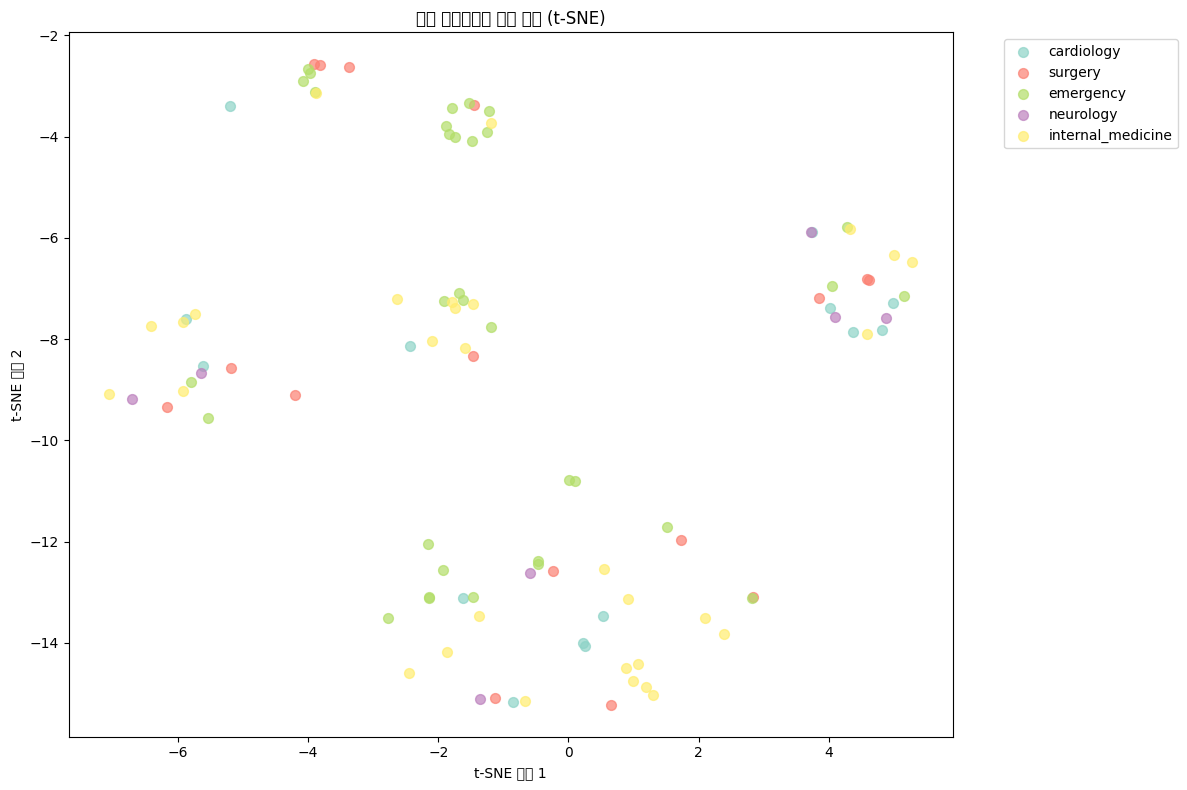

‚úÖ ÏãúÍ∞ÅÌôî ÏôÑÎ£å

üìã ÏµúÏ¢Ö Í≤ÄÏ¶ù Í≤∞Í≥º
Basic Info: ‚úÖ PASS
Metadata: ‚úÖ PASS
Search Quality: ‚úÖ PASS
Similarity: ‚úÖ PASS
Distribution: ‚úÖ PASS

üéØ Ï†ÑÏ≤¥ Ï†êÏàò: 100.0% (5/5)
üéâ Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥Í∞Ä ÏÑ±Í≥µÏ†ÅÏúºÎ°ú Íµ¨Ï∂ïÎêòÏóàÏäµÎãàÎã§!


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from collections import Counter
import seaborn as sns

class VectorStoreValidator:
    """
    Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥ Í≤ÄÏ¶ù Î∞è ÌÖåÏä§Ìä∏ ÌÅ¥ÎûòÏä§
    """
    
    def __init__(self, vector_store, medical_vector_store_e5_unified):
        self.vector_store = vector_store  # MedicalVectorStoreE5 Ïù∏Ïä§ÌÑ¥Ïä§
        self.medical_vector_store_e5_unified = medical_vector_store_e5_unified  # FAISS Î≤°ÌÑ∞Ïä§ÌÜ†Ïñ¥ Í∞ùÏ≤¥
        
    def basic_info_check(self):
        """
        Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥ Í∏∞Î≥∏ Ï†ïÎ≥¥ ÌôïÏù∏
        """
        print("=" * 60)
        print("üîç Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥ Í∏∞Î≥∏ Ï†ïÎ≥¥ Í≤ÄÏ¶ù")
        print("=" * 60)
        
        try:
            # Î≤°ÌÑ∞ Í∞úÏàò ÌôïÏù∏
            total_vectors = self.medical_vector_store_e5_unified.index.ntotal
            print(f"‚úÖ Ï¥ù Î≤°ÌÑ∞ Í∞úÏàò: {total_vectors:,}Í∞ú")
            
            # Î≤°ÌÑ∞ Ï∞®Ïõê ÌôïÏù∏
            vector_dim = self.medical_vector_store_e5_unified.index.d
            print(f"‚úÖ Î≤°ÌÑ∞ Ï∞®Ïõê: {vector_dim}Ï∞®Ïõê")
            
            # Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ ÌôïÏù∏
            if hasattr(self.medical_vector_store_e5_unified, 'docstore'):
                doc_count = len(self.medical_vector_store_e5_unified.docstore._dict)
                print(f"‚úÖ Ï†ÄÏû•Îêú Î¨∏ÏÑú Ïàò: {doc_count:,}Í∞ú")
            
            # Ïù∏Îç±Ïä§ ÌÉÄÏûÖ ÌôïÏù∏
            index_type = type(self.medical_vector_store_e5_unified.index).__name__
            print(f"‚úÖ Ïù∏Îç±Ïä§ ÌÉÄÏûÖ: {index_type}")
            
            return True
            
        except Exception as e:
            print(f"‚ùå Í∏∞Î≥∏ Ï†ïÎ≥¥ ÌôïÏù∏ Ïã§Ìå®: {e}")
            return False
    
    def metadata_analysis(self):
        """
        Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ Î∂ÑÏÑù
        """
        print("\n" + "=" * 60)
        print("üìä Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ Î∂ÑÏÑù")
        print("=" * 60)
        
        try:
            if not hasattr(self.medical_vector_store_e5_unified, 'docstore'):
                print("‚ùå Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ Ï†ëÍ∑º Î∂àÍ∞Ä")
                return False
            
            # Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ ÏàòÏßë
            all_metadata = []
            for doc_id, doc in self.medical_vector_store_e5_unified.docstore._dict.items():
                if hasattr(doc, 'metadata'):
                    all_metadata.append(doc.metadata)
            
            print(f"‚úÖ Î©îÌÉÄÎç∞Ïù¥ÌÑ∞Í∞Ä ÏûàÎäî Î¨∏ÏÑú: {len(all_metadata)}Í∞ú")
            
            # ÏßÑÎ£åÍ≥ºÎ≥Ñ Î∂ÑÌè¨
            departments = [meta.get('department', 'Unknown') for meta in all_metadata]
            dept_counter = Counter(departments)
            print(f"\nüìã ÏßÑÎ£åÍ≥ºÎ≥Ñ Î¨∏ÏÑú Î∂ÑÌè¨:")
            for dept, count in dept_counter.most_common():
                print(f"  - {dept}: {count}Í∞ú")
            
            # Î¨∏ÏÑú ÌÉÄÏûÖÎ≥Ñ Î∂ÑÌè¨
            doc_types = [meta.get('document_type', 'Unknown') for meta in all_metadata]
            type_counter = Counter(doc_types)
            print(f"\nüìã Î¨∏ÏÑú ÌÉÄÏûÖÎ≥Ñ Î∂ÑÌè¨:")
            for doc_type, count in type_counter.most_common():
                print(f"  - {doc_type}: {count}Í∞ú")
            
            # ÏÑ±Î≥Ñ Î∂ÑÌè¨
            genders = [meta.get('gender', 'Unknown') for meta in all_metadata]
            gender_counter = Counter(genders)
            print(f"\nüìã ÏÑ±Î≥Ñ Î∂ÑÌè¨:")
            for gender, count in gender_counter.items():
                print(f"  - {gender}: {count}Í∞ú")
            
            return True
            
        except Exception as e:
            print(f"‚ùå Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ Î∂ÑÏÑù Ïã§Ìå®: {e}")
            return False
    
    def search_quality_test(self):
        """
        Í≤ÄÏÉâ ÌíàÏßà ÌÖåÏä§Ìä∏
        """
        print("\n" + "=" * 60)
        print("üîç Í≤ÄÏÉâ ÌíàÏßà ÌÖåÏä§Ìä∏")
        print("=" * 60)
        
        # Îã§ÏñëÌïú ÌÖåÏä§Ìä∏ ÏøºÎ¶¨
        test_queries = [
            ("ÎãπÎá®Î≥ë", "diabetes"),
            ("Í≥†ÌòàÏïï", "hypertension"),  
            ("Ïã¨Ïû•", "heart"),
            ("ÏàòÏà†", "surgery"),
            ("ÏïΩÎ¨º", "medication"),
            ("Í≤ÄÏÇ¨", "test"),
            ("ÏßÑÎã®", "diagnosis"),
            ("Ïó¨ÏÑ± ÌôòÏûê", "female patient"),
            ("ÏùëÍ∏âÏã§", "emergency"),
            ("ÎÇ¥Í≥º", "internal medicine")
        ]
        
        successful_searches = 0
        total_results = 0
        
        for korean_query, english_desc in test_queries:
            try:
                print(f"\nüîç ÌÖåÏä§Ìä∏ ÏøºÎ¶¨: '{korean_query}' ({english_desc})")
                
                # Í≤ÄÏÉâ Ïã§Ìñâ - vector_storeÏùò search_similar_documents Î©îÏÑúÎìú ÏÇ¨Ïö©
                results = self.vector_store.search_similar_documents(
                    korean_query, 
                    self.medical_vector_store_e5_unified, 
                    k=3
                )
                
                if results:
                    print(f"‚úÖ Í≤ÄÏÉâ ÏÑ±Í≥µ: {len(results)}Í∞ú Í≤∞Í≥º")
                    successful_searches += 1
                    total_results += len(results)
                    
                    # Ï≤´ Î≤àÏß∏ Í≤∞Í≥º ÎØ∏Î¶¨Î≥¥Í∏∞
                    first_result = results[0]
                    print(f"   üë§ ÌôòÏûê: {first_result.metadata.get('name', 'N/A')}")
                    print(f"   üè• ÏßÑÎ£åÍ≥º: {first_result.metadata.get('department', 'N/A')}")
                    print(f"   üìÑ Î¨∏ÏÑúÌÉÄÏûÖ: {first_result.metadata.get('document_type', 'N/A')}")
                    print(f"   üìù ÎÇ¥Ïö©: {first_result.page_content[:100]}...")
                else:
                    print(f"‚ùå Í≤ÄÏÉâ Ïã§Ìå®: Í≤∞Í≥º ÏóÜÏùå")
                    
            except Exception as e:
                print(f"‚ùå Í≤ÄÏÉâ Ïò§Î•ò: {e}")
        
        success_rate = (successful_searches / len(test_queries)) * 100
        avg_results = total_results / successful_searches if successful_searches > 0 else 0
        
        print(f"\nüìä Í≤ÄÏÉâ ÏÑ±Îä• ÏöîÏïΩ:")
        print(f"   ÏÑ±Í≥µÎ•†: {success_rate:.1f}% ({successful_searches}/{len(test_queries)})")
        print(f"   ÌèâÍ∑† Í≤∞Í≥º Ïàò: {avg_results:.1f}Í∞ú")
        
        return success_rate >= 80  # 80% Ïù¥ÏÉÅ ÏÑ±Í≥µÌïòÎ©¥ PASS
    
    def similarity_test(self):
        """
        Ïú†ÏÇ¨ÎèÑ ÌíàÏßà ÌÖåÏä§Ìä∏
        """
        print("\n" + "=" * 60)
        print("üìè Ïú†ÏÇ¨ÎèÑ ÌíàÏßà ÌÖåÏä§Ìä∏")
        print("=" * 60)
        
        try:
            # Í¥ÄÎ†®ÏÑ±Ïù¥ ÎÜíÏùÄ ÏøºÎ¶¨ ÏåçÎì§Î°ú ÌÖåÏä§Ìä∏
            related_pairs = [
                # 1. ÎãπÎá®Î≥ë Í¥ÄÎ†® Ïåç
                ("ÎãπÎá®Î≥ë", "ÌòàÎãπÏù¥ ÎÜíÏùÄ ÌôòÏûê"),
                ("ÎãπÎá®Î≥ë", "Ïù∏ÏäêÎ¶∞ ÏπòÎ£å"),
                ("Ï†ú2Ìòï ÎãπÎá®Î≥ë", "ÌòàÎãπ Ï°∞Ï†à"),
                
                # 2. Í≥†ÌòàÏïï Í¥ÄÎ†® Ïåç  
                ("Í≥†ÌòàÏïï", "ÌòàÏïïÏù¥ ÎÜíÏùÄ ÌôòÏûê"),
                ("Í≥†ÌòàÏïï", "ÌòàÏïïÏïΩ"),
                ("Í≥†ÌòàÏïï", "ÏàòÏ∂ïÍ∏∞ ÌòàÏïï"),
                
                # 3. Ïã¨Ïû•ÏßàÌôò Í¥ÄÎ†® Ïåç
                ("Ïã¨Ïû•Î≥ë", "Ïã¨Í∑ºÍ≤ΩÏÉâ"),
                ("Ïã¨Ïû•Î≥ë", "ÌùâÌÜµ"),
                ("Î∂ÄÏ†ïÎß•", "Ïã¨Ï†ÑÎèÑ"),
                ("ÌòëÏã¨Ï¶ù", "Í∞ÄÏä¥ ÌÜµÏ¶ù"),
                
                # 4. Ìò∏Ìù°Í∏∞ Í¥ÄÎ†® Ïåç
                ("ÌèêÎ†¥", "Í∏∞Ïπ®"),
                ("Ï≤úÏãù", "Ìò∏Ìù°Í≥§ÎûÄ"),
                ("ÌèêÎ†¥", "Î∞úÏó¥"),
                
                # 5. ÏÜåÌôîÍ∏∞ Í¥ÄÎ†® Ïåç
                ("ÏúÑÏóº", "Î≥µÌÜµ"),
                ("ÏúÑÍ∂§Ïñë", "ÏÜç Ïì∞Î¶º"),
                ("Í∞ÑÏóº", "Í∞Ñ Í∏∞Îä• Í≤ÄÏÇ¨"),
                
                # 6. Ïã†Í≤ΩÍ≥Ñ Í¥ÄÎ†® Ïåç
                ("ÎáåÏ°∏Ï§ë", "ÎßàÎπÑ Ï¶ùÏÉÅ"),
                ("ÎëêÌÜµ", "Ìé∏ÎëêÌÜµ"),
                ("ÏπòÎß§", "Í∏∞ÏñµÎ†• Ï†ÄÌïò"),
                
                # 7. Í≤ÄÏÇ¨ Í¥ÄÎ†® Ïåç
                ("ÌòàÏï°Í≤ÄÏÇ¨", "CBC"),
                ("ÏòÅÏÉÅÍ≤ÄÏÇ¨", "CT Ï¥¨ÏòÅ"),
                ("Ïã¨Ï†ÑÎèÑ", "EKG"),
                
                # 8. ÏπòÎ£å Í¥ÄÎ†® Ïåç
                ("ÏàòÏà†", "Ï†ÑÏã†ÎßàÏ∑®"),
                ("ÏïΩÎ¨ºÏπòÎ£å", "Ï≤òÎ∞©Ï†Ñ"),
                ("Î¨ºÎ¶¨ÏπòÎ£å", "Ïû¨Ìôú"),
                
                # 9. Ï¶ùÏÉÅ Í¥ÄÎ†® Ïåç
                ("Î∞úÏó¥", "Ï≤¥Ïò® ÏÉÅÏäπ"),
                ("Ïñ¥ÏßÄÎü¨ÏõÄ", "ÌòÑÍ∏∞Ï¶ù"),
                ("Íµ¨ÌÜ†", "Î©îÏä§Í∫ºÏõÄ"),
                
                # 10. ÏùëÍ∏âÏÉÅÌô© Í¥ÄÎ†® Ïåç
                ("ÏùëÍ∏âÏã§", "ÏùëÍ∏âÌôòÏûê"),
                ("ÏáºÌÅ¨", "ÌòàÏïï Ï†ÄÌïò"),
                ("Ïã¨Ï†ïÏßÄ", "Ïã¨ÌèêÏÜåÏÉùÏà†")
            ]
            
            similarity_scores = []
            
            for query1, query2 in related_pairs:
                print(f"\nüîç Ïó∞Í¥Ä ÏøºÎ¶¨ ÌÖåÏä§Ìä∏: '{query1}' vs '{query2}'")
                
                # Í∞ÅÍ∞Å Í≤ÄÏÉâ
                results1 = self.vector_store.search_similar_documents(query1, self.medical_vector_store_e5_unified, k=5)
                results2 = self.vector_store.search_similar_documents(query2, self.medical_vector_store_e5_unified, k=5)
                
                if results1 and results2:
                    # Í≤∞Í≥º Î¨∏ÏÑúÎì§Ïùò ÌôòÏûê ID ÎπÑÍµê
                    patients1 = set(doc.metadata.get('patient_id') for doc in results1)
                    patients2 = set(doc.metadata.get('patient_id') for doc in results2)
                    
                    # ÍµêÏßëÌï© ÎπÑÏú® Í≥ÑÏÇ∞ (Í¥ÄÎ†®ÏÑ± ÏßÄÌëú)
                    overlap = len(patients1.intersection(patients2))
                    total_unique = len(patients1.union(patients2))
                    similarity = overlap / total_unique if total_unique > 0 else 0
                    
                    similarity_scores.append(similarity)
                    print(f"   üìä ÌôòÏûê Í≤πÏπ®Î•†: {similarity:.2%} ({overlap}/{total_unique})")
                else:
                    print(f"   ‚ùå Í≤ÄÏÉâ Ïã§Ìå®")
            
            if similarity_scores:
                avg_similarity = np.mean(similarity_scores)
                print(f"\nüìä ÌèâÍ∑† Ïó∞Í¥ÄÏÑ± Ï†êÏàò: {avg_similarity:.2%}")
                return avg_similarity >= 0.1  # 10% Ïù¥ÏÉÅ Í≤πÏπòÎ©¥ PASS
            else:
                return False
                
        except Exception as e:
            print(f"‚ùå Ïú†ÏÇ¨ÎèÑ ÌÖåÏä§Ìä∏ Ïã§Ìå®: {e}")
            return False
    
    def vector_distribution_analysis(self, sample_size=100):
        """
        Î≤°ÌÑ∞ Î∂ÑÌè¨ Î∂ÑÏÑù (ÏãúÍ∞ÅÌôî)
        """
        print("\n" + "=" * 60)
        print("üìà Î≤°ÌÑ∞ Î∂ÑÌè¨ Î∂ÑÏÑù")
        print("=" * 60)
        
        try:
            # ÏÉòÌîå Î≤°ÌÑ∞ Ï∂îÏ∂ú
            total_vectors = self.medical_vector_store_e5_unified.index.ntotal
            sample_indices = np.random.choice(
                total_vectors, 
                min(sample_size, total_vectors), 
                replace=False
            )
            
            # Î≤°ÌÑ∞ Îç∞Ïù¥ÌÑ∞ Ï∂îÏ∂ú
            sample_vectors = []
            sample_metadata = []
            
            for idx in sample_indices:
                vector = self.medical_vector_store_e5_unified.index.reconstruct(int(idx))
                sample_vectors.append(vector)
                
                # Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ Í∞ÄÏ†∏Ïò§Í∏∞
                if hasattr(self.medical_vector_store_e5_unified, 'docstore'):
                    doc_id = list(self.medical_vector_store_e5_unified.docstore._dict.keys())[idx]
                    doc = self.medical_vector_store_e5_unified.docstore._dict[doc_id]
                    if hasattr(doc, 'metadata'):
                        sample_metadata.append(doc.metadata)
                    else:
                        sample_metadata.append({})
                else:
                    sample_metadata.append({})
            
            sample_vectors = np.array(sample_vectors)
            print(f"‚úÖ {len(sample_vectors)}Í∞ú Î≤°ÌÑ∞ ÏÉòÌîå Ï∂îÏ∂ú")
            
            # Í∏∞Î≥∏ ÌÜµÍ≥Ñ
            print(f"üìä Î≤°ÌÑ∞ ÌÜµÍ≥Ñ:")
            print(f"   ÌèâÍ∑† ÌÅ¨Í∏∞: {np.mean(np.linalg.norm(sample_vectors, axis=1)):.4f}")
            print(f"   ÌëúÏ§ÄÌé∏Ï∞®: {np.std(np.linalg.norm(sample_vectors, axis=1)):.4f}")
            print(f"   ÏµúÏÜåÍ∞í: {np.min(sample_vectors):.4f}")
            print(f"   ÏµúÎåÄÍ∞í: {np.max(sample_vectors):.4f}")
            
            # t-SNEÎ°ú 2D ÏãúÍ∞ÅÌôî
            if len(sample_vectors) >= 10:
                print("\nüé® t-SNE ÏãúÍ∞ÅÌôî ÏÉùÏÑ± Ï§ë...")
                tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(sample_vectors)-1))
                vectors_2d = tsne.fit_transform(sample_vectors)
                
                # ÏßÑÎ£åÍ≥ºÎ≥Ñ ÏÉâÏÉÅ Îß§Ìïë
                departments = [meta.get('department', 'Unknown') for meta in sample_metadata]
                unique_depts = list(set(departments))
                colors = plt.cm.Set3(np.linspace(0, 1, len(unique_depts)))
                dept_color_map = dict(zip(unique_depts, colors))
                
                plt.figure(figsize=(12, 8))
                
                for dept in unique_depts:
                    dept_indices = [i for i, d in enumerate(departments) if d == dept]
                    if dept_indices:
                        plt.scatter(
                            vectors_2d[dept_indices, 0], 
                            vectors_2d[dept_indices, 1],
                            c=[dept_color_map[dept]], 
                            label=dept, 
                            alpha=0.7,
                            s=50
                        )
                
                plt.title('Î≤°ÌÑ∞ Í≥µÍ∞ÑÏóêÏÑúÏùò Î¨∏ÏÑú Î∂ÑÌè¨ (t-SNE)')
                plt.xlabel('t-SNE Ï∞®Ïõê 1')
                plt.ylabel('t-SNE Ï∞®Ïõê 2')
                plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
                plt.tight_layout()
                plt.show()
                
                print("‚úÖ ÏãúÍ∞ÅÌôî ÏôÑÎ£å")
            
            return True
            
        except Exception as e:
            print(f"‚ùå Î≤°ÌÑ∞ Î∂ÑÌè¨ Î∂ÑÏÑù Ïã§Ìå®: {e}")
            import traceback
            print(traceback.format_exc())
            return False
    
    def comprehensive_validation(self):
        """
        Ï¢ÖÌï© Í≤ÄÏ¶ù Ïã§Ìñâ
        """
        print("üöÄ Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥ Ï¢ÖÌï© Í≤ÄÏ¶ù ÏãúÏûë")
        print("=" * 80)
        
        results = {
            'basic_info': self.basic_info_check(),
            'metadata': self.metadata_analysis(),
            'search_quality': self.search_quality_test(),
            'similarity': self.similarity_test(),
            'distribution': self.vector_distribution_analysis()
        }
        
        print("\n" + "=" * 80)
        print("üìã ÏµúÏ¢Ö Í≤ÄÏ¶ù Í≤∞Í≥º")
        print("=" * 80)
        
        passed_tests = 0
        total_tests = len(results)
        
        for test_name, result in results.items():
            status = "‚úÖ PASS" if result else "‚ùå FAIL"
            print(f"{test_name.replace('_', ' ').title()}: {status}")
            if result:
                passed_tests += 1
        
        overall_score = (passed_tests / total_tests) * 100
        print(f"\nüéØ Ï†ÑÏ≤¥ Ï†êÏàò: {overall_score:.1f}% ({passed_tests}/{total_tests})")
        
        if overall_score >= 80:
            print("üéâ Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥Í∞Ä ÏÑ±Í≥µÏ†ÅÏúºÎ°ú Íµ¨Ï∂ïÎêòÏóàÏäµÎãàÎã§!")
        elif overall_score >= 60:
            print("‚ö†Ô∏è  Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥Í∞Ä Íµ¨Ï∂ïÎêòÏóàÏßÄÎßå ÏùºÎ∂Ä Í∞úÏÑ†Ïù¥ ÌïÑÏöîÌï©ÎãàÎã§.")
        else:
            print("‚ùå Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥Ïóê Ïã¨Í∞ÅÌïú Î¨∏Ï†úÍ∞Ä ÏûàÏäµÎãàÎã§. Ïû¨Íµ¨Ï∂ïÏùÑ Í∂åÏû•Ìï©ÎãàÎã§.")
        
        return overall_score >= 60

# ÏÇ¨Ïö© ÏòàÏãú
if __name__ == "__main__":
    # Î®ºÏ†Ä Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥ Î°úÎìú
    vector_store = MedicalVectorStoreE5(
        data_path="./medical_data",
        vector_store_path="./vector_stores",
        use_gpu=True
    )
    
    # Ï†ÄÏû•Îêú Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥ Î°úÎìú
    medical_vector_store_e5_unified = vector_store.load_vector_store(
        store_name="medical_vector_store_e5_unified"
    )
    
    if medical_vector_store_e5_unified is not None:
        print("‚úÖ Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥ Î°úÎìú ÏôÑÎ£å!")
        
        # Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥ Í≤ÄÏ¶ù Ïã§Ìñâ
        validator = VectorStoreValidator(vector_store, medical_vector_store_e5_unified)
        validator.comprehensive_validation()
    else:
        print("‚ùå Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥Î•º Î°úÎìúÌï† Ïàò ÏóÜÏäµÎãàÎã§.")
        print("Î≤°ÌÑ∞ Ïä§ÌÜ†Ïñ¥Í∞Ä './vector_stores/medical_vector_store_e5_unified' Í≤ΩÎ°úÏóê ÏûàÎäîÏßÄ ÌôïÏù∏Ìï¥Ï£ºÏÑ∏Ïöî.")